In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.58it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.03it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.76it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.09it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  34.2506:   5%|██▊                                                    | 1/20 [00:21<03:53, 12.31s/it]

Epoch   1, Train Regret:  24.5034%, Val Regret:  24.2981%


Epoch    1, Loss:  19.2669:  10%|█████▌                                                 | 2/20 [00:32<03:21, 11.21s/it]

Epoch   2, Train Regret:  21.8651%, Val Regret:  22.1734%


Epoch    2, Loss:  23.4411:  15%|████████▎                                              | 3/20 [00:42<03:04, 10.83s/it]

Epoch   3, Train Regret:  20.6678%, Val Regret:  20.6605%


Epoch    3, Loss:  21.6620:  20%|███████████                                            | 4/20 [00:53<02:51, 10.75s/it]

Epoch   4, Train Regret:  19.7073%, Val Regret:  19.6866%


Epoch    4, Loss:   8.4527:  25%|█████████████▊                                         | 5/20 [01:03<02:40, 10.67s/it]

Epoch   5, Train Regret:  18.1748%, Val Regret:  18.4411%


Epoch    5, Loss:  11.9667:  30%|████████████████▌                                      | 6/20 [01:15<02:28, 10.58s/it]

Epoch   6, Train Regret:  16.3925%, Val Regret:  16.9329%


Epoch    6, Loss:   9.6950:  35%|███████████████████▎                                   | 7/20 [01:26<02:22, 10.95s/it]

Epoch   7, Train Regret:  15.3700%, Val Regret:  15.7292%


Epoch    7, Loss:   5.8913:  40%|██████████████████████                                 | 8/20 [01:36<02:12, 11.02s/it]

Epoch   8, Train Regret:  14.5283%, Val Regret:  14.9727%


Epoch    8, Loss:   9.1741:  45%|████████████████████████▊                              | 9/20 [01:47<01:58, 10.77s/it]

Epoch   9, Train Regret:  13.9677%, Val Regret:  14.6126%


Epoch    9, Loss:   8.1964:  50%|███████████████████████████                           | 10/20 [01:58<01:47, 10.79s/it]

Epoch  10, Train Regret:  13.7533%, Val Regret:  14.6126%


Epoch   10, Loss:  12.2435:  55%|█████████████████████████████▋                        | 11/20 [02:08<01:36, 10.77s/it]

Epoch  11, Train Regret:  13.4047%, Val Regret:  14.0823%


Epoch   11, Loss:  10.8563:  60%|████████████████████████████████▍                     | 12/20 [02:19<01:25, 10.66s/it]

Epoch  12, Train Regret:  13.1978%, Val Regret:  13.7226%


Epoch   12, Loss:  10.1927:  65%|███████████████████████████████████                   | 13/20 [02:29<01:14, 10.58s/it]

Epoch  13, Train Regret:  13.3223%, Val Regret:  13.9320%


Epoch   13, Loss:  13.8770:  70%|█████████████████████████████████████▊                | 14/20 [02:39<01:02, 10.48s/it]

Epoch  14, Train Regret:  13.2145%, Val Regret:  13.5664%


Epoch   14, Loss:   6.6662:  75%|████████████████████████████████████████▌             | 15/20 [02:49<00:51, 10.40s/it]

Epoch  15, Train Regret:  13.2562%, Val Regret:  13.6719%


Epoch   15, Loss:  16.8497:  80%|███████████████████████████████████████████▏          | 16/20 [03:00<00:41, 10.36s/it]

Epoch  16, Train Regret:  13.0987%, Val Regret:  13.3092%


Epoch   16, Loss:   6.7349:  85%|█████████████████████████████████████████████▉        | 17/20 [03:11<00:31, 10.43s/it]

Epoch  17, Train Regret:  13.2471%, Val Regret:  13.3661%


Epoch   17, Loss:   8.5397:  90%|████████████████████████████████████████████████▌     | 18/20 [03:22<00:21, 10.70s/it]

Epoch  18, Train Regret:  13.1883%, Val Regret:  13.4162%


Epoch   18, Loss:   8.5746:  95%|███████████████████████████████████████████████████▎  | 19/20 [03:33<00:11, 11.23s/it]


Epoch  19, Train Regret:  13.3162%, Val Regret:  13.5088%

Early Stop!

Evaluation:
Test Regret: 13.5085%
Training Elapsed Time: 2.32 Sec


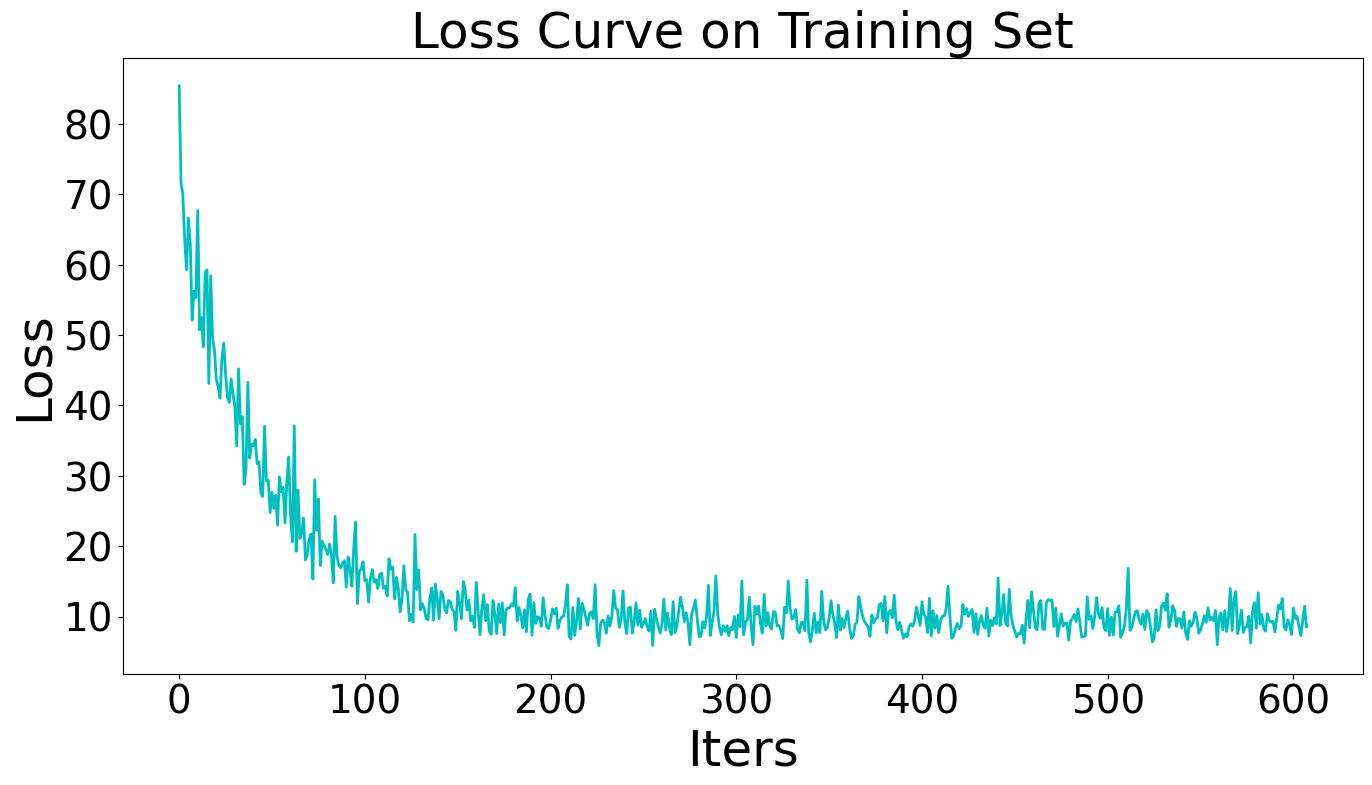

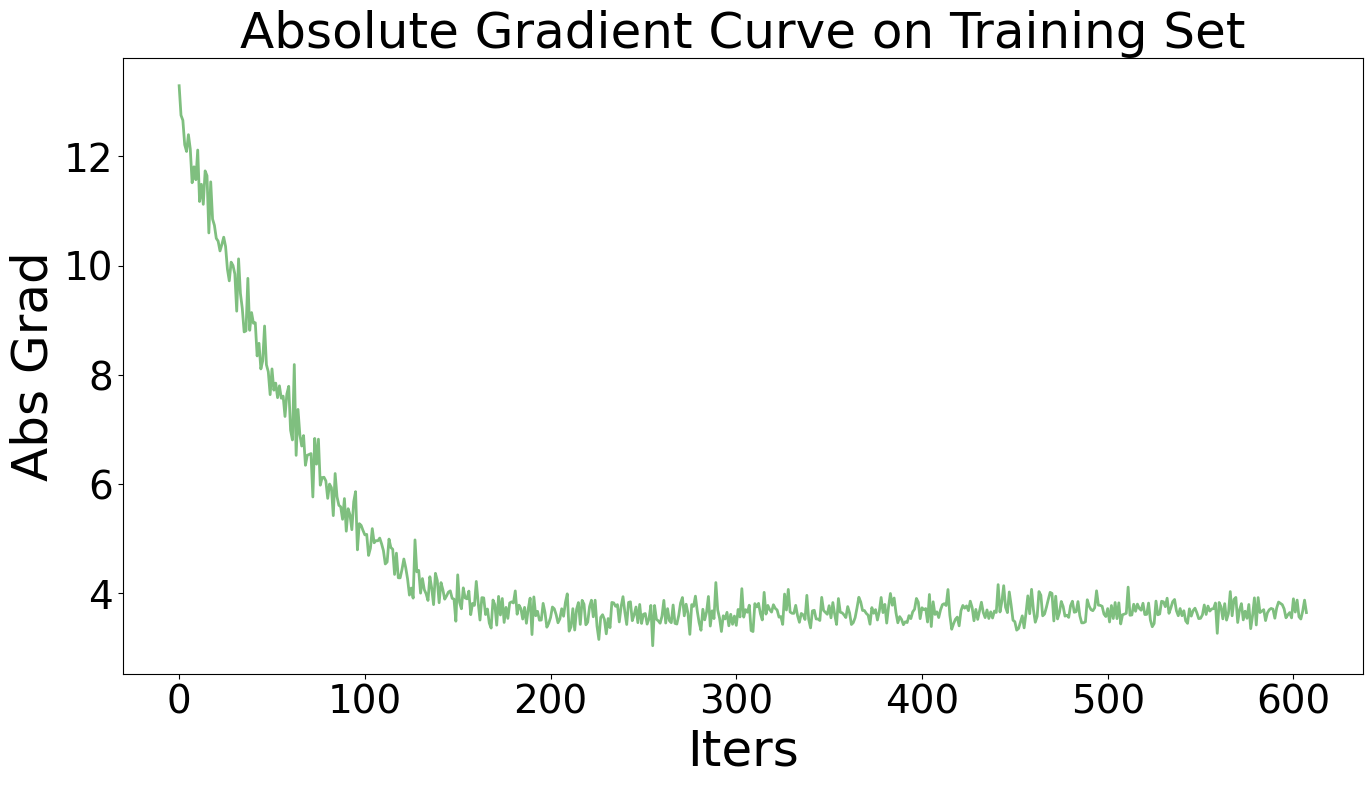

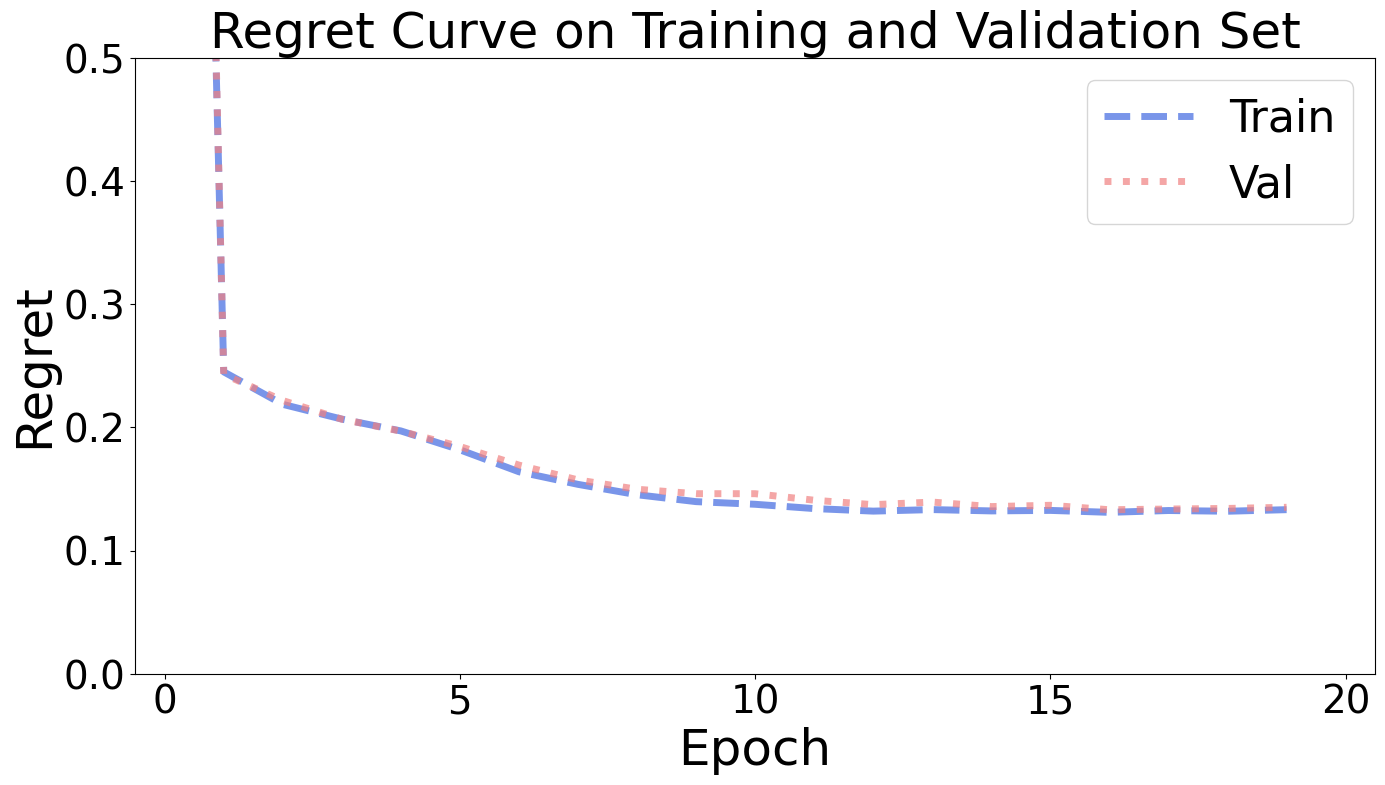

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 04 03:42:19 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 206.4504%, Val Regret: 210.3446%


Epoch    0, Loss:  -0.9973:   5%|██▊                                                    | 1/20 [00:35<08:18, 26.24s/it]

Epoch   1, Train Regret:  11.3955%, Val Regret:  12.4876%


Epoch    1, Loss:  -0.9984:  10%|█████▌                                                 | 2/20 [00:56<06:52, 22.94s/it]

Epoch   2, Train Regret:   8.2735%, Val Regret:   9.0998%


Epoch    2, Loss:  -0.9988:  15%|████████▎                                              | 3/20 [01:17<06:13, 21.99s/it]

Epoch   3, Train Regret:   7.1709%, Val Regret:   8.0982%


Epoch    3, Loss:  -0.9996:  20%|███████████                                            | 4/20 [01:39<05:48, 21.78s/it]

Epoch   4, Train Regret:   6.9633%, Val Regret:   8.2193%


Epoch    4, Loss:  -0.9996:  25%|█████████████▊                                         | 5/20 [01:59<05:21, 21.43s/it]

Epoch   5, Train Regret:   6.7131%, Val Regret:   7.8406%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [02:20<04:56, 21.21s/it]

Epoch   6, Train Regret:   6.6994%, Val Regret:   7.6676%


Epoch    6, Loss:  -0.9991:  35%|███████████████████▎                                   | 7/20 [02:38<04:25, 20.43s/it]

Epoch   7, Train Regret:   6.8023%, Val Regret:   7.9296%


Epoch    7, Loss:  -0.9994:  40%|██████████████████████                                 | 8/20 [02:57<03:59, 19.98s/it]

Epoch   8, Train Regret:   6.8204%, Val Regret:   7.3081%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [03:17<03:37, 19.78s/it]

Epoch   9, Train Regret:   6.7058%, Val Regret:   7.8426%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [03:37<03:14, 19.49s/it]

Epoch  10, Train Regret:   6.8195%, Val Regret:   7.4588%


Epoch   10, Loss:  -0.9996:  55%|█████████████████████████████▋                        | 11/20 [03:56<03:13, 21.50s/it]


Epoch  11, Train Regret:   6.8169%, Val Regret:   7.3527%

Early Stop!

Evaluation:
Test Regret: 7.1923%
Training Elapsed Time: 110.05 Sec


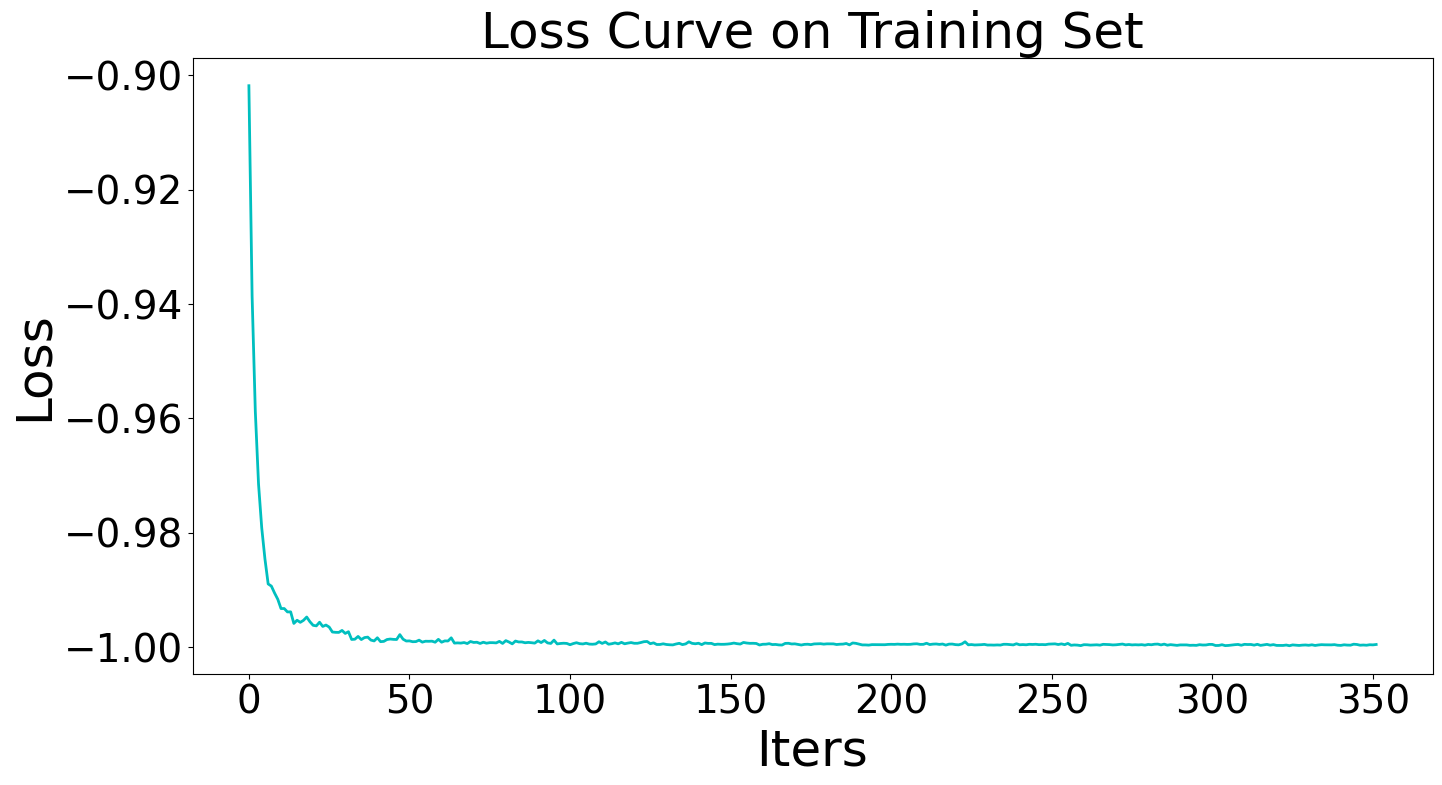

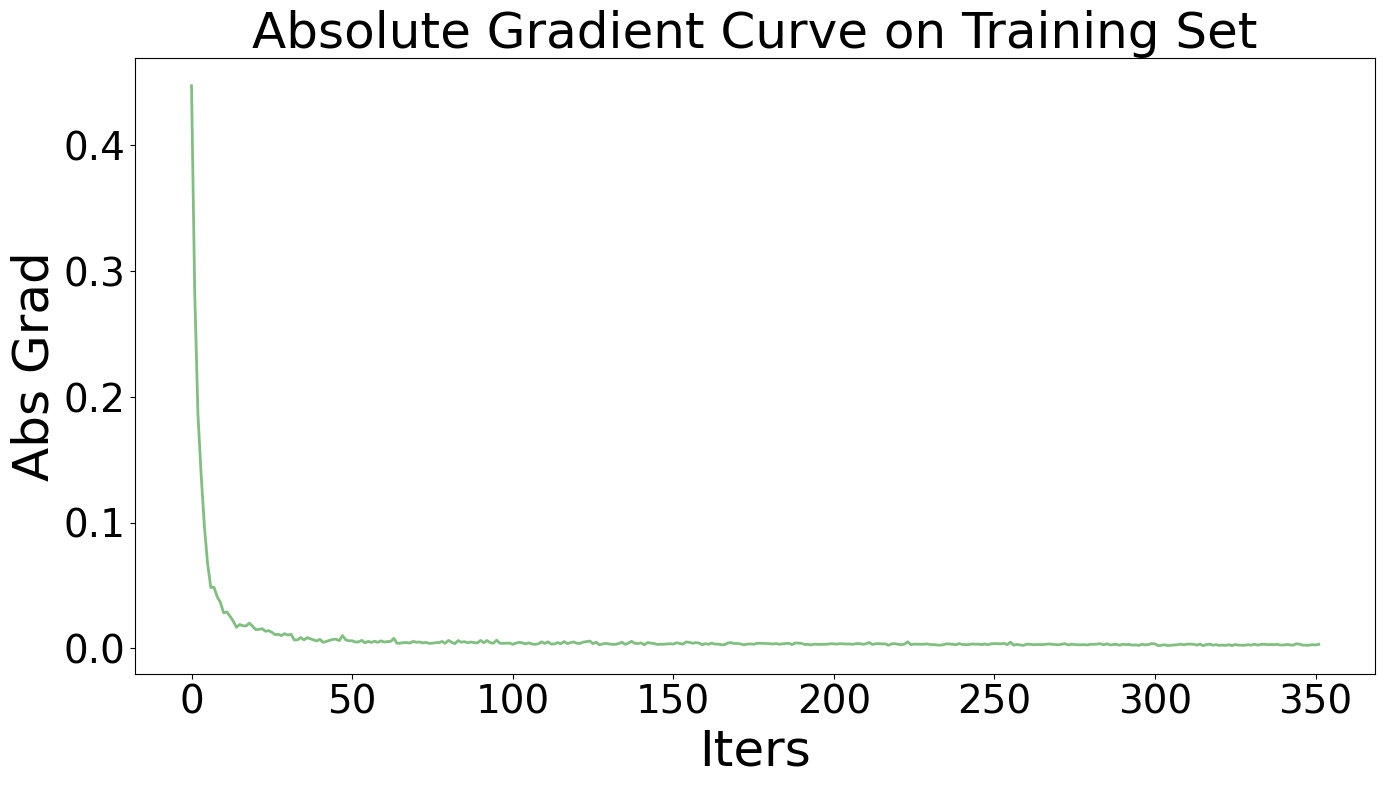

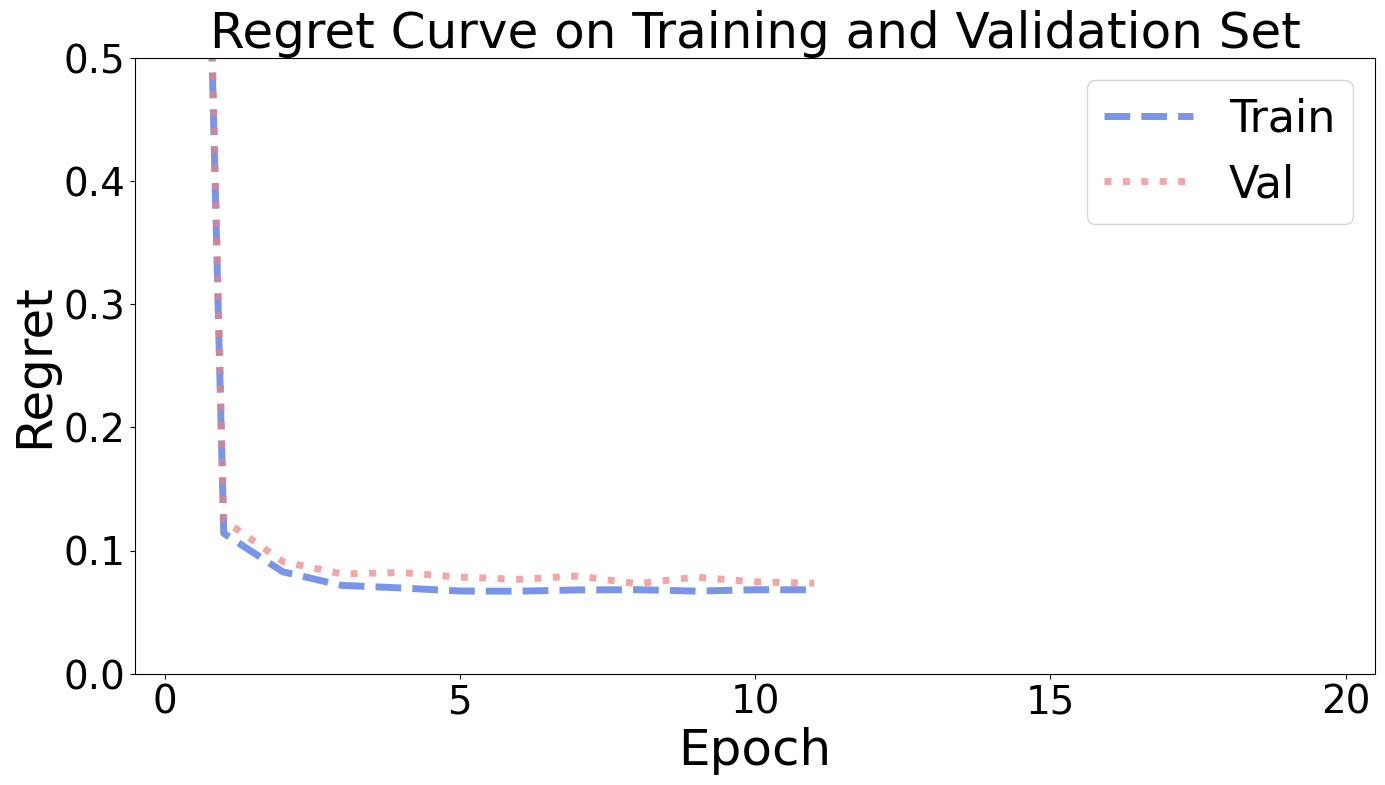

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [22]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 196.7550%, Val Regret: 196.5337%


Epoch    0, Loss:  -0.9973:   5%|██▊                                                    | 1/20 [00:28<05:59, 18.92s/it]

Epoch   1, Train Regret:  10.5588%, Val Regret:  12.3355%


Epoch    1, Loss:  -0.9983:  10%|█████▌                                                 | 2/20 [00:47<05:41, 18.97s/it]

Epoch   2, Train Regret:   7.1147%, Val Regret:   7.6237%


Epoch    2, Loss:  -0.9987:  15%|████████▎                                              | 3/20 [01:08<05:36, 19.80s/it]

Epoch   3, Train Regret:   6.4373%, Val Regret:   6.7303%


Epoch    3, Loss:  -0.9995:  20%|███████████                                            | 4/20 [01:30<05:24, 20.27s/it]

Epoch   4, Train Regret:   6.4475%, Val Regret:   7.3630%


Epoch    4, Loss:  -0.9994:  25%|█████████████▊                                         | 5/20 [01:51<05:14, 20.99s/it]

Epoch   5, Train Regret:   6.2478%, Val Regret:   6.9461%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [02:13<05:10, 22.21s/it]


Epoch   6, Train Regret:   6.4548%, Val Regret:   7.1983%

Early Stop!

Evaluation:
Test Regret: 6.8728%
Training Elapsed Time: 58.21 Sec


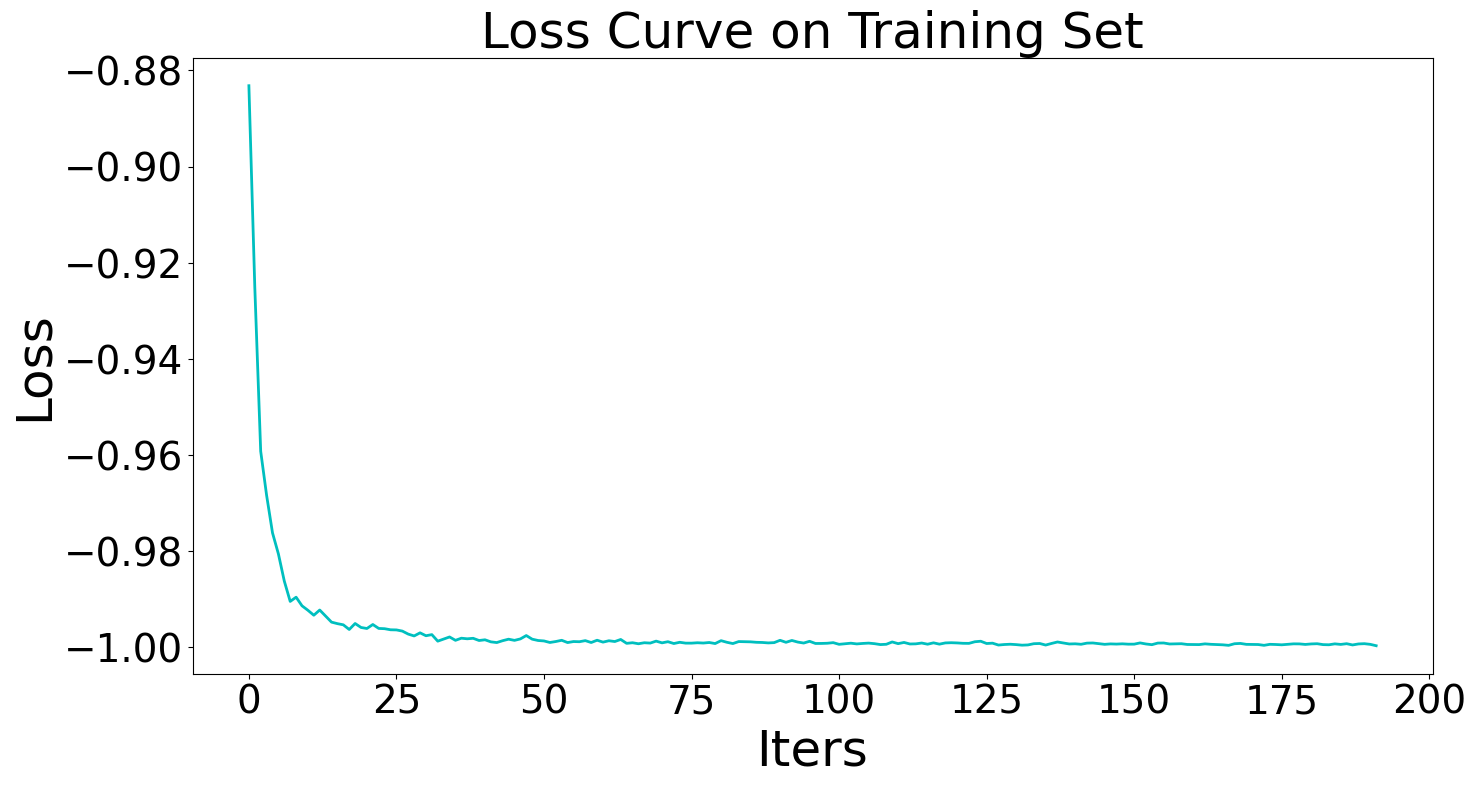

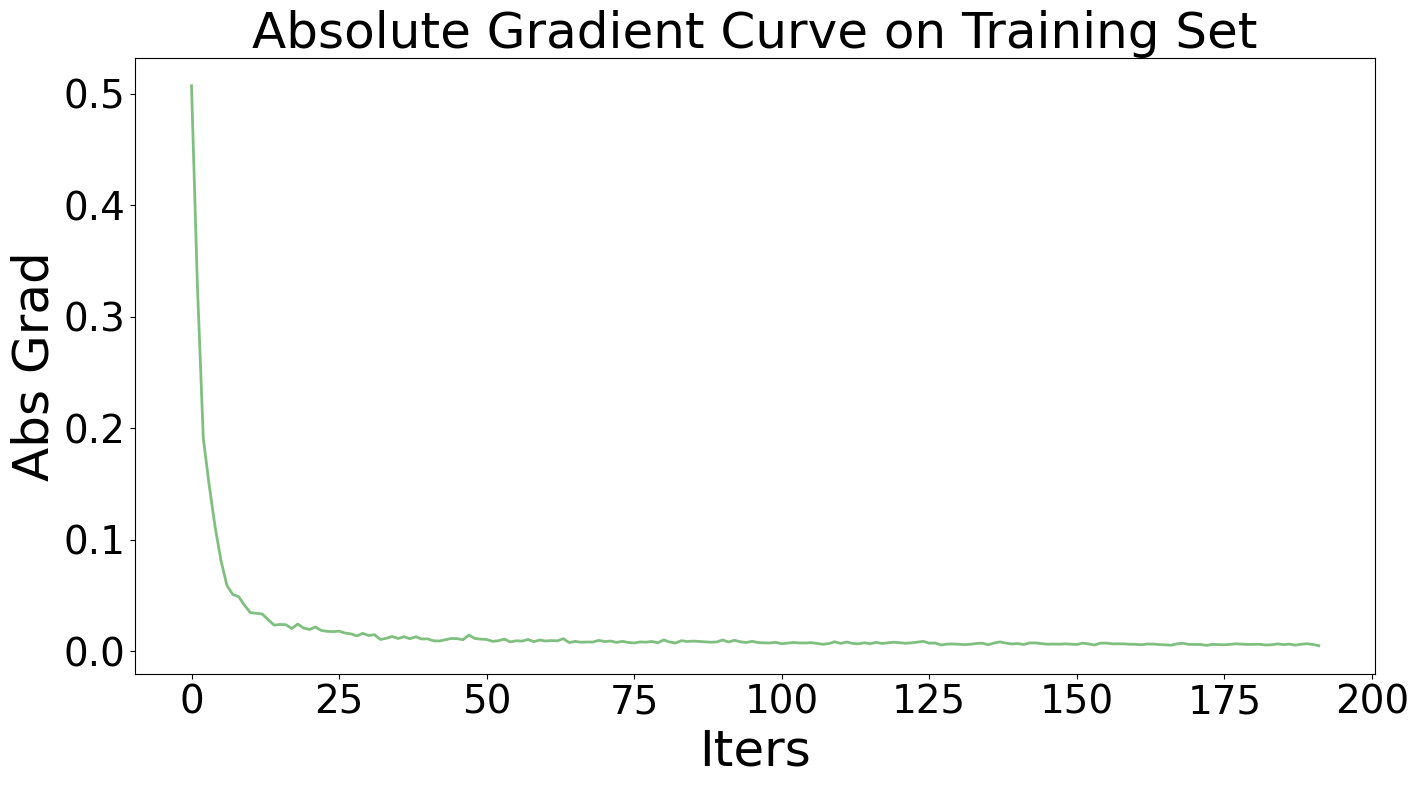

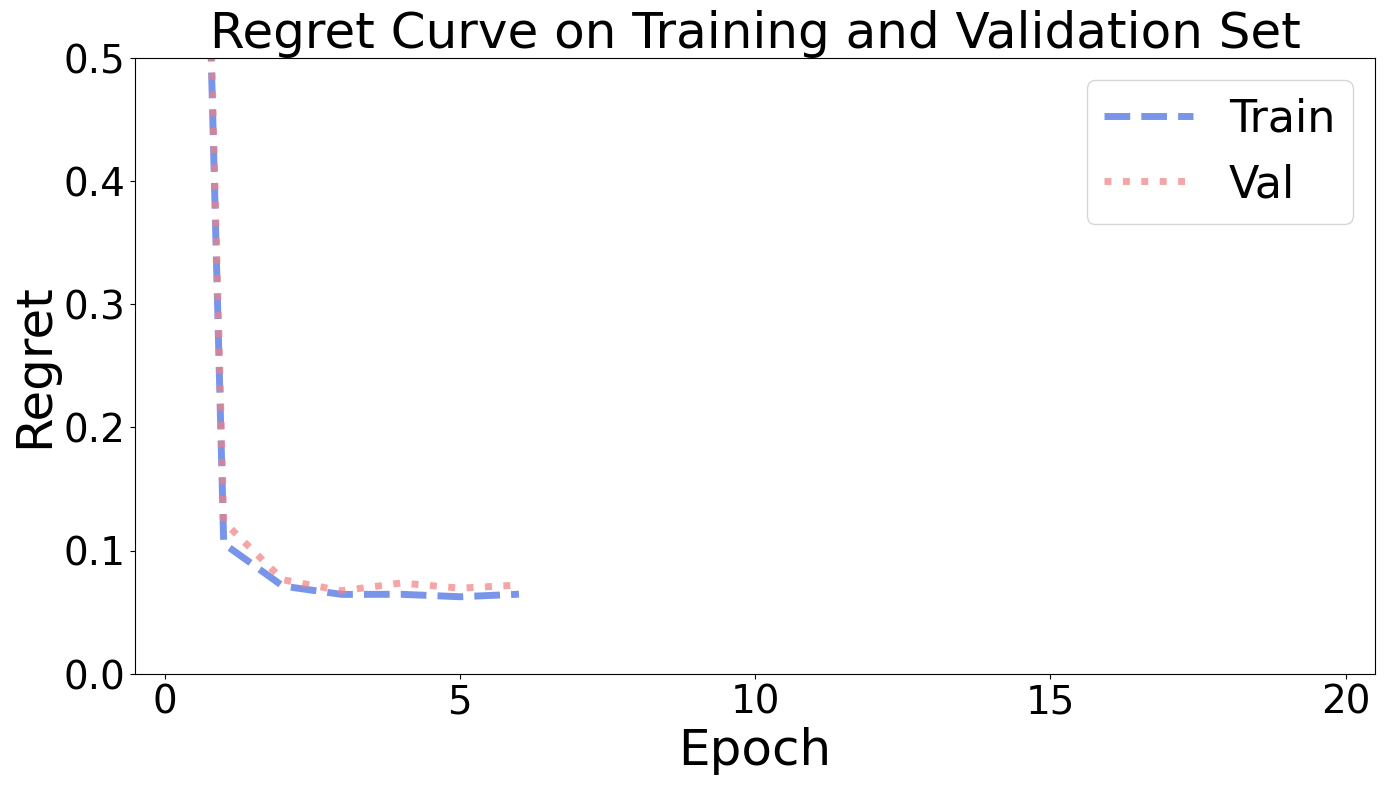

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.1, processes=8)

Num of cores: 8


In [26]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 204.8412%, Val Regret: 214.6115%


Epoch    0, Loss:  -1.0000:   5%|██▊                                                    | 1/20 [00:20<03:32, 11.18s/it]

Epoch   1, Train Regret:  18.2558%, Val Regret:  19.2787%


Epoch    1, Loss:  -1.0000:  10%|█████▌                                                 | 2/20 [00:32<03:27, 11.50s/it]

Epoch   2, Train Regret:  10.5028%, Val Regret:  10.1424%


Epoch    2, Loss:  -1.0000:  15%|████████▎                                              | 3/20 [00:44<03:17, 11.62s/it]

Epoch   3, Train Regret:  10.6545%, Val Regret:  11.1194%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [00:55<03:05, 11.58s/it]

Epoch   4, Train Regret:  11.1239%, Val Regret:  11.7691%


Epoch    4, Loss:  -1.0000:  25%|█████████████▊                                         | 5/20 [01:08<03:25, 13.73s/it]


Epoch   5, Train Regret:  11.2639%, Val Regret:  12.0076%

Early Stop!

Evaluation:
Test Regret: 11.2287%
Training Elapsed Time: 5.91 Sec


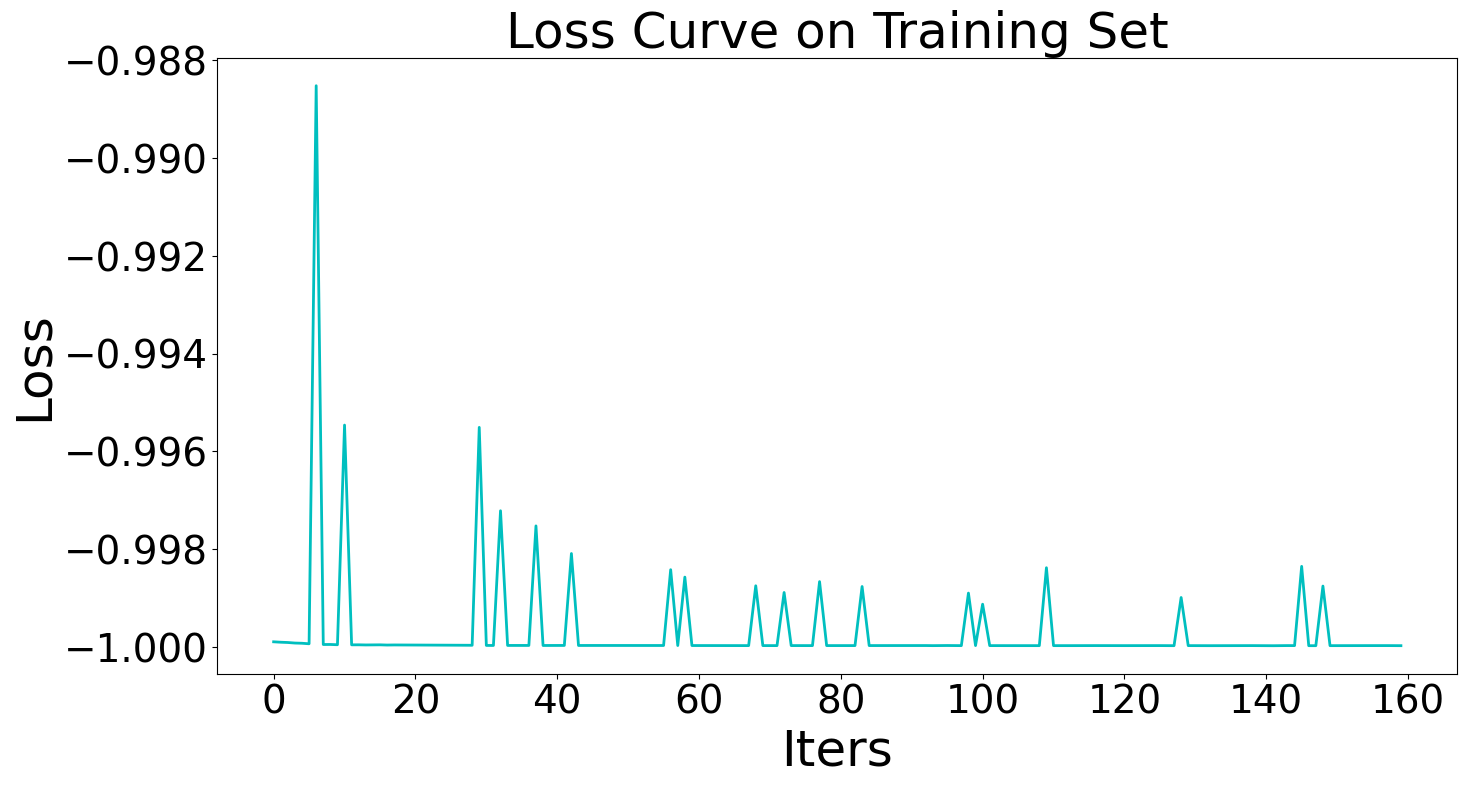

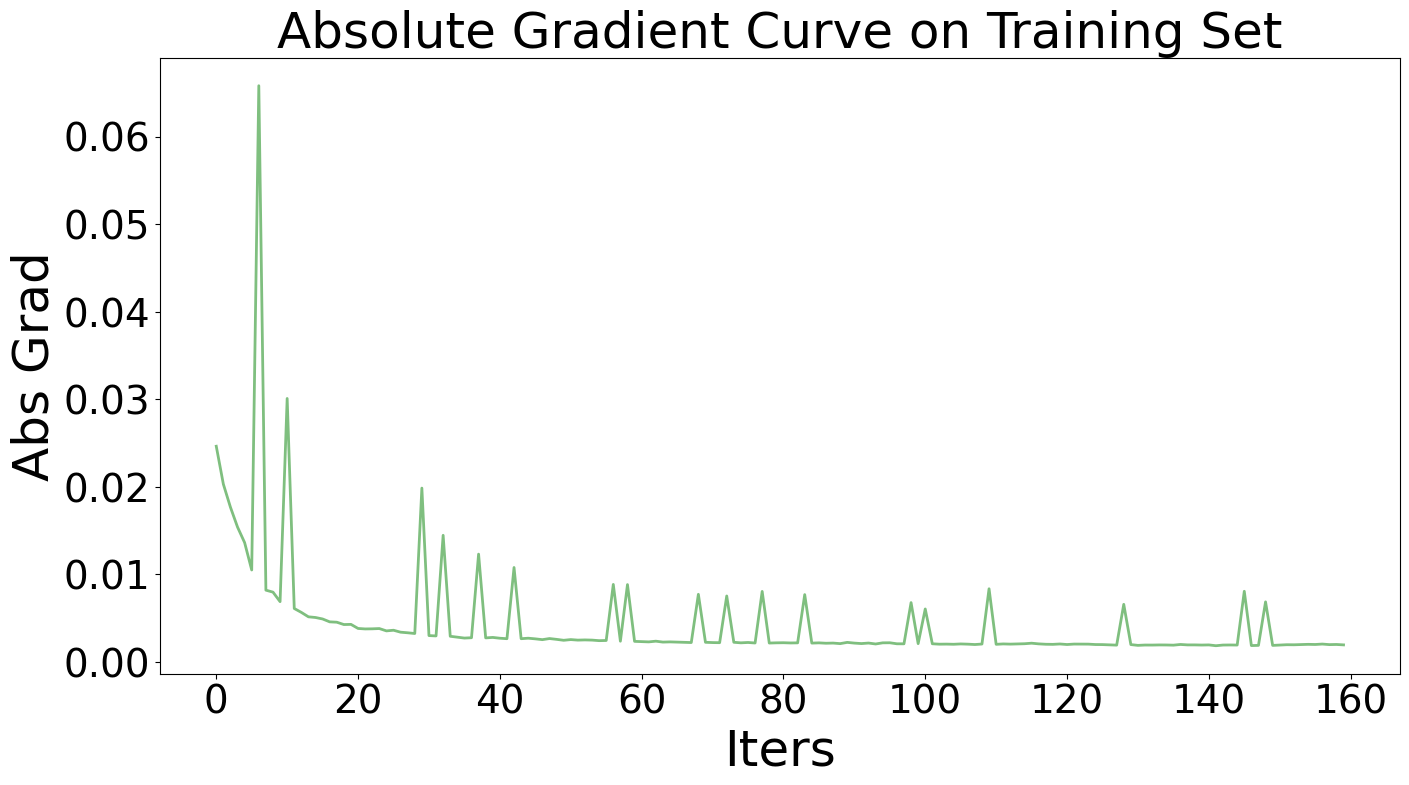

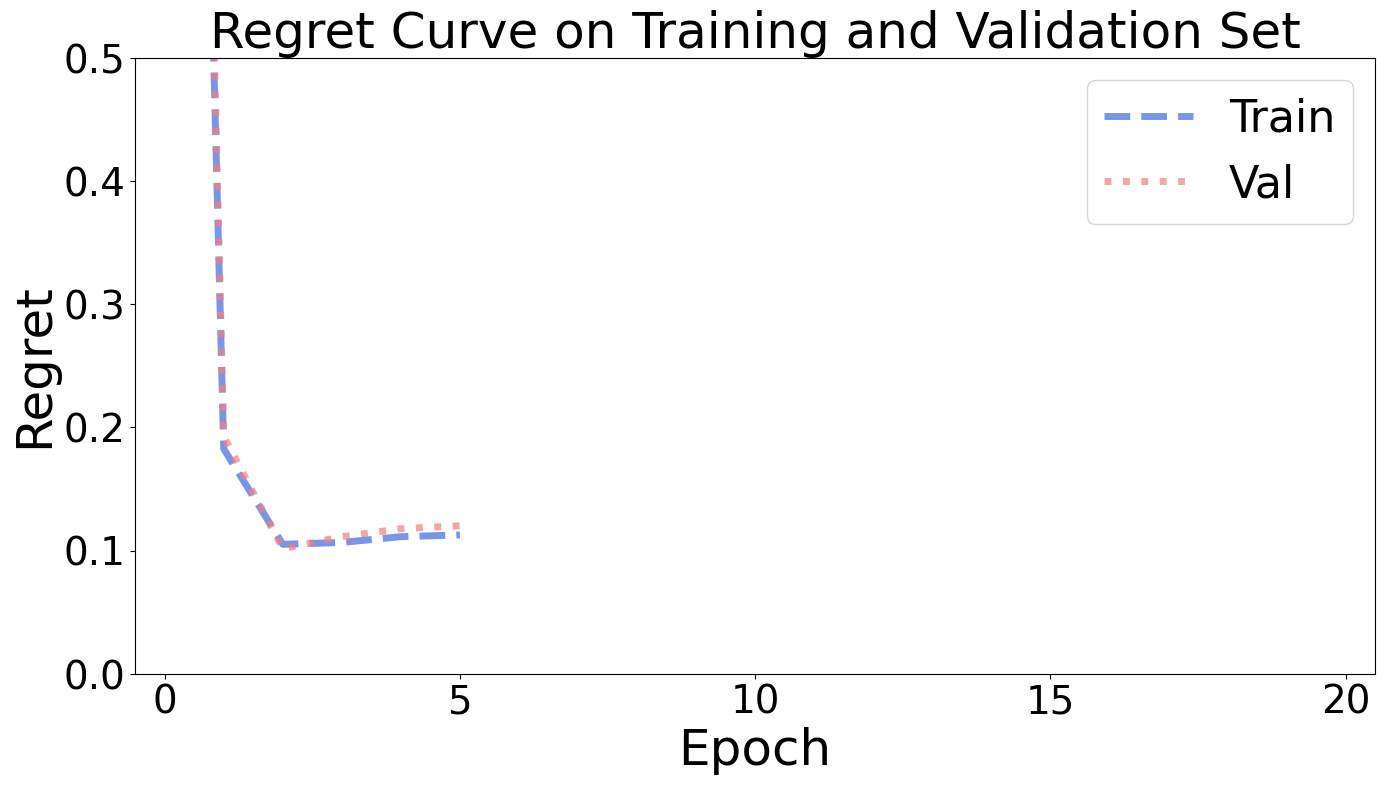

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [30]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 188.6278%, Val Regret: 199.1169%


Epoch    0, Loss:  -0.9999:   5%|██▊                                                    | 1/20 [00:20<03:35, 11.35s/it]

Epoch   1, Train Regret:  17.2755%, Val Regret:  18.5597%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:32<03:23, 11.29s/it]

Epoch   2, Train Regret:  14.1751%, Val Regret:  13.2427%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:43<03:12, 11.30s/it]

Epoch   3, Train Regret:  15.0844%, Val Regret:  15.9492%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:54<03:00, 11.27s/it]

Epoch   4, Train Regret:  14.4067%, Val Regret:  14.7582%


Epoch    4, Loss:  -0.9999:  25%|█████████████▊                                         | 5/20 [01:06<03:18, 13.22s/it]


Epoch   5, Train Regret:  14.9779%, Val Regret:  15.7760%

Early Stop!

Evaluation:
Test Regret: 14.6274%
Training Elapsed Time: 3.70 Sec


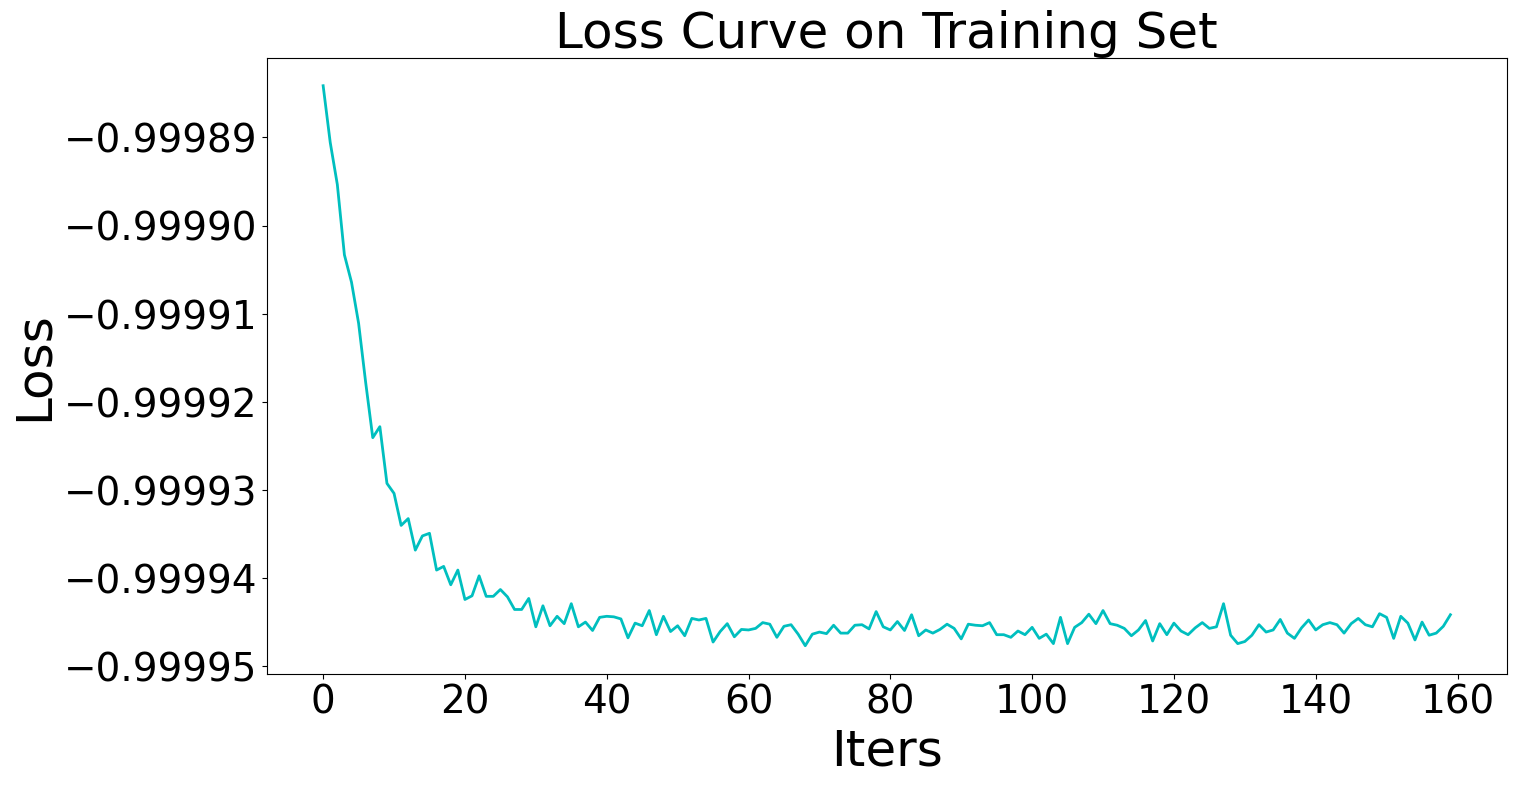

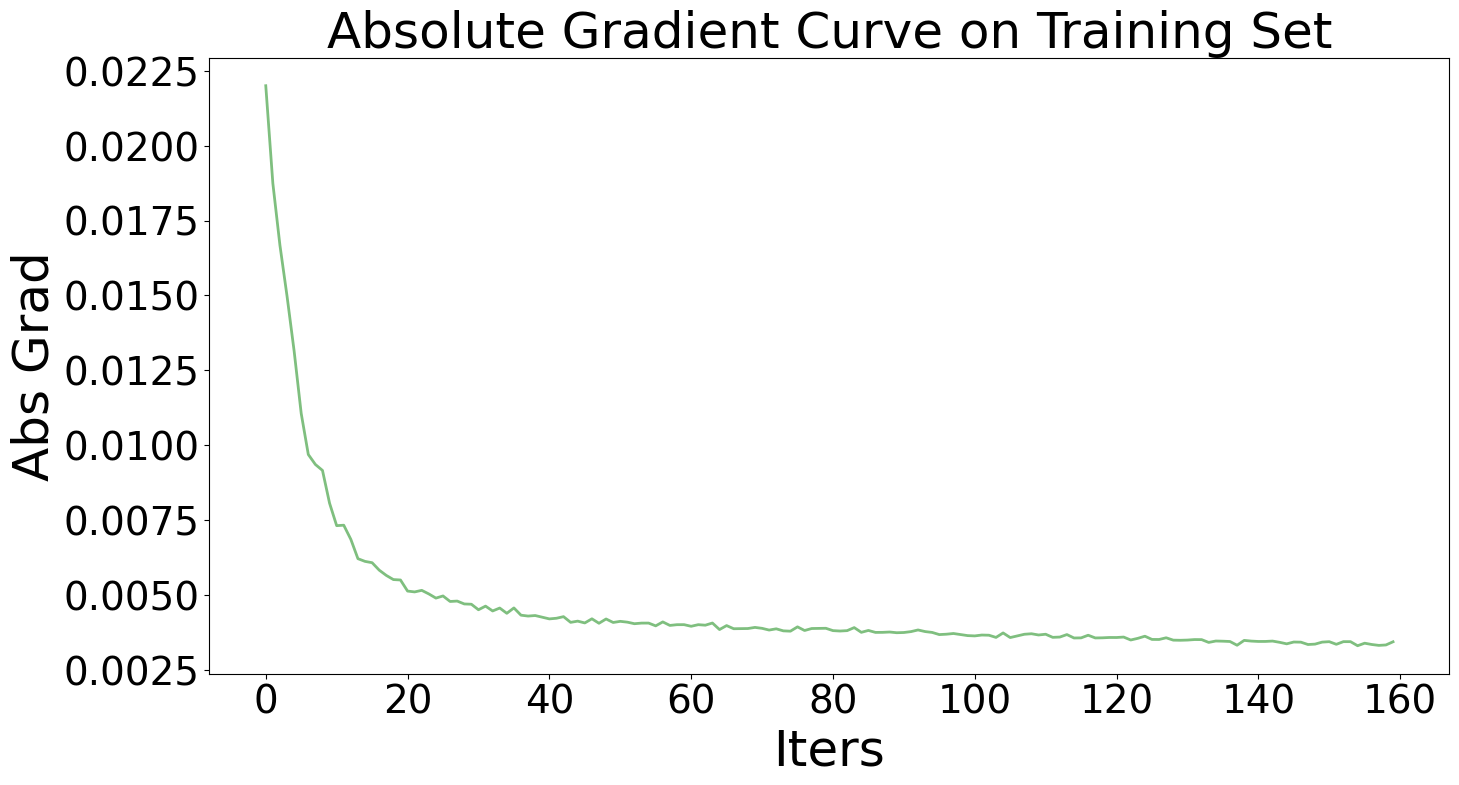

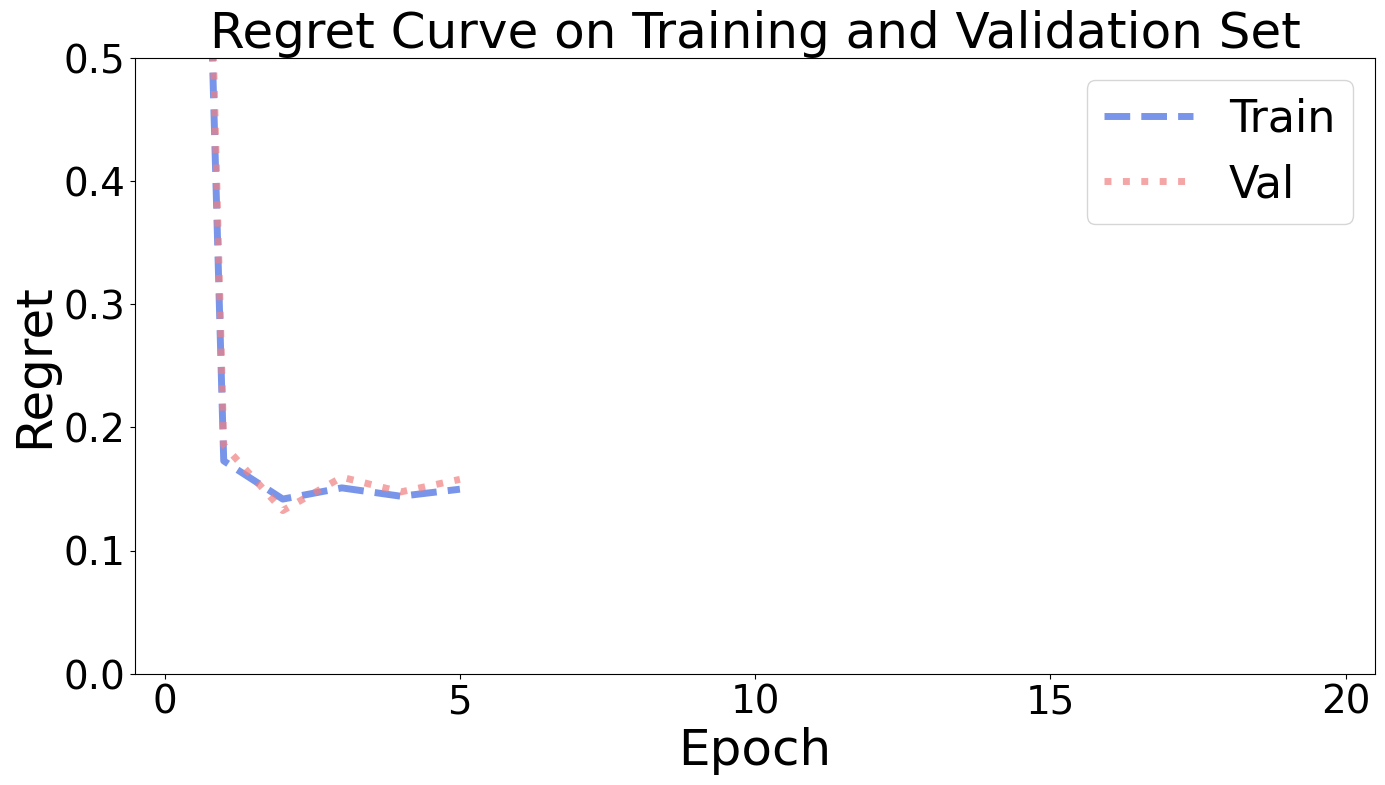

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [34]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 197.8213%, Val Regret: 208.0420%


Epoch    0, Loss:  -0.9999:   5%|██▊                                                    | 1/20 [00:24<04:30, 14.23s/it]

Epoch   1, Train Regret:  16.6876%, Val Regret:  17.7031%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:39<04:27, 14.88s/it]

Epoch   2, Train Regret:  14.3441%, Val Regret:  13.7243%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:54<04:15, 15.01s/it]

Epoch   3, Train Regret:  14.7175%, Val Regret:  14.4847%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [01:09<03:59, 14.97s/it]

Epoch   4, Train Regret:  13.9972%, Val Regret:  13.3081%


Epoch    4, Loss:  -0.9999:  25%|█████████████▊                                         | 5/20 [01:23<03:41, 14.76s/it]

Epoch   5, Train Regret:  13.8897%, Val Regret:  15.3233%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [01:38<03:24, 14.62s/it]

Epoch   6, Train Regret:  14.1498%, Val Regret:  15.3567%


Epoch    6, Loss:  -0.9999:  35%|███████████████████▎                                   | 7/20 [01:52<03:10, 14.62s/it]

Epoch   7, Train Regret:  13.8412%, Val Regret:  13.1760%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [02:06<02:53, 14.47s/it]

Epoch   8, Train Regret:  13.7879%, Val Regret:  14.9148%


Epoch    8, Loss:  -0.9999:  45%|████████████████████████▊                              | 9/20 [02:21<02:39, 14.50s/it]

Epoch   9, Train Regret:  14.0643%, Val Regret:  14.4284%


Epoch    9, Loss:  -0.9999:  50%|███████████████████████████                           | 10/20 [02:37<02:26, 14.66s/it]

Epoch  10, Train Regret:  13.4936%, Val Regret:  12.4061%


Epoch   10, Loss:  -0.9999:  55%|█████████████████████████████▋                        | 11/20 [02:52<02:14, 14.97s/it]

Epoch  11, Train Regret:  13.9823%, Val Regret:  13.0922%


Epoch   11, Loss:  -0.9999:  60%|████████████████████████████████▍                     | 12/20 [03:06<01:58, 14.84s/it]

Epoch  12, Train Regret:  14.0833%, Val Regret:  15.2361%


Epoch   12, Loss:  -0.9999:  65%|███████████████████████████████████                   | 13/20 [03:21<01:48, 15.49s/it]


Epoch  13, Train Regret:  13.3336%, Val Regret:  13.4439%

Early Stop!

Evaluation:
Test Regret: 13.9667%
Training Elapsed Time: 51.25 Sec


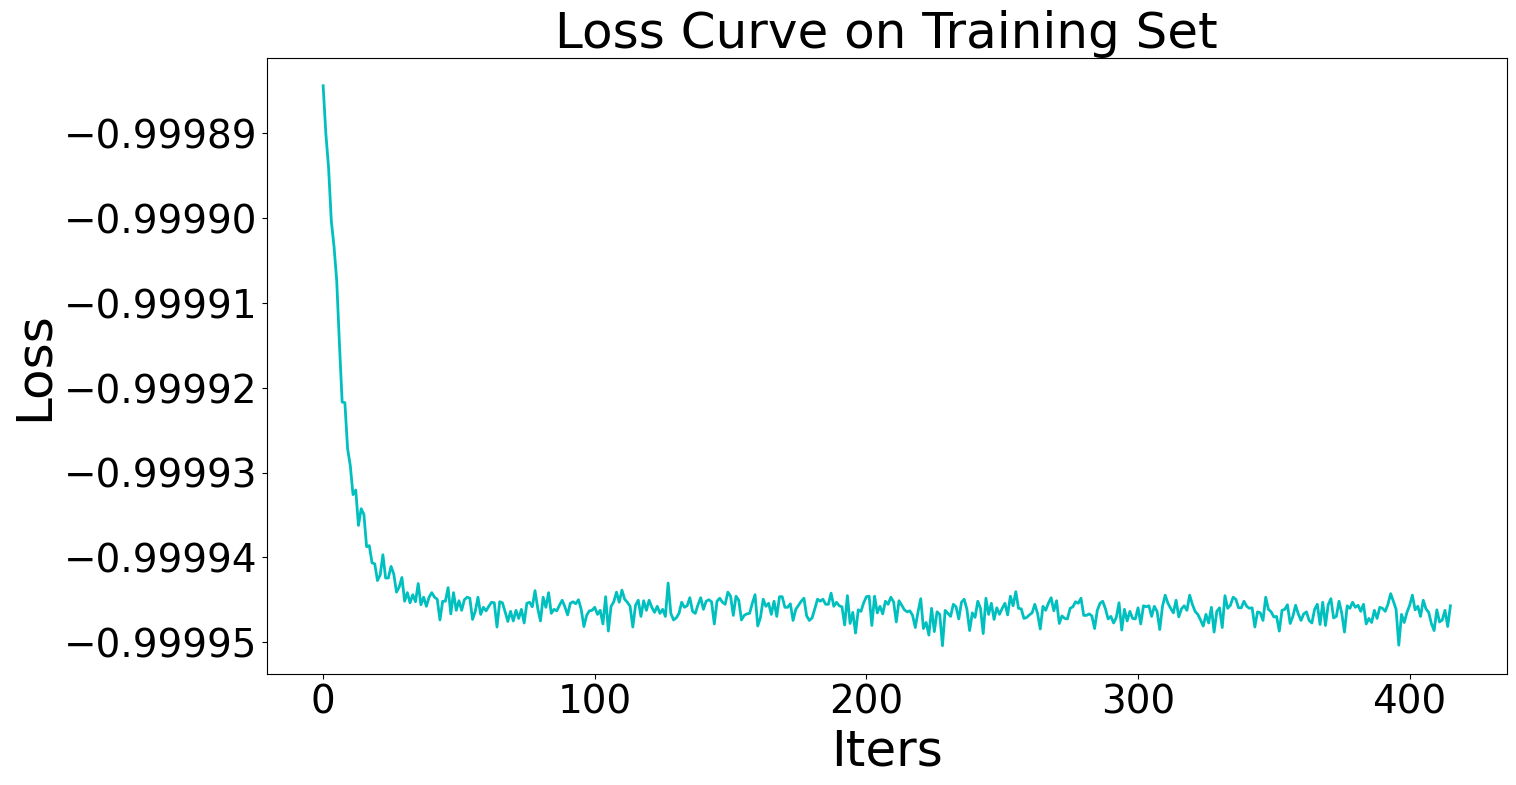

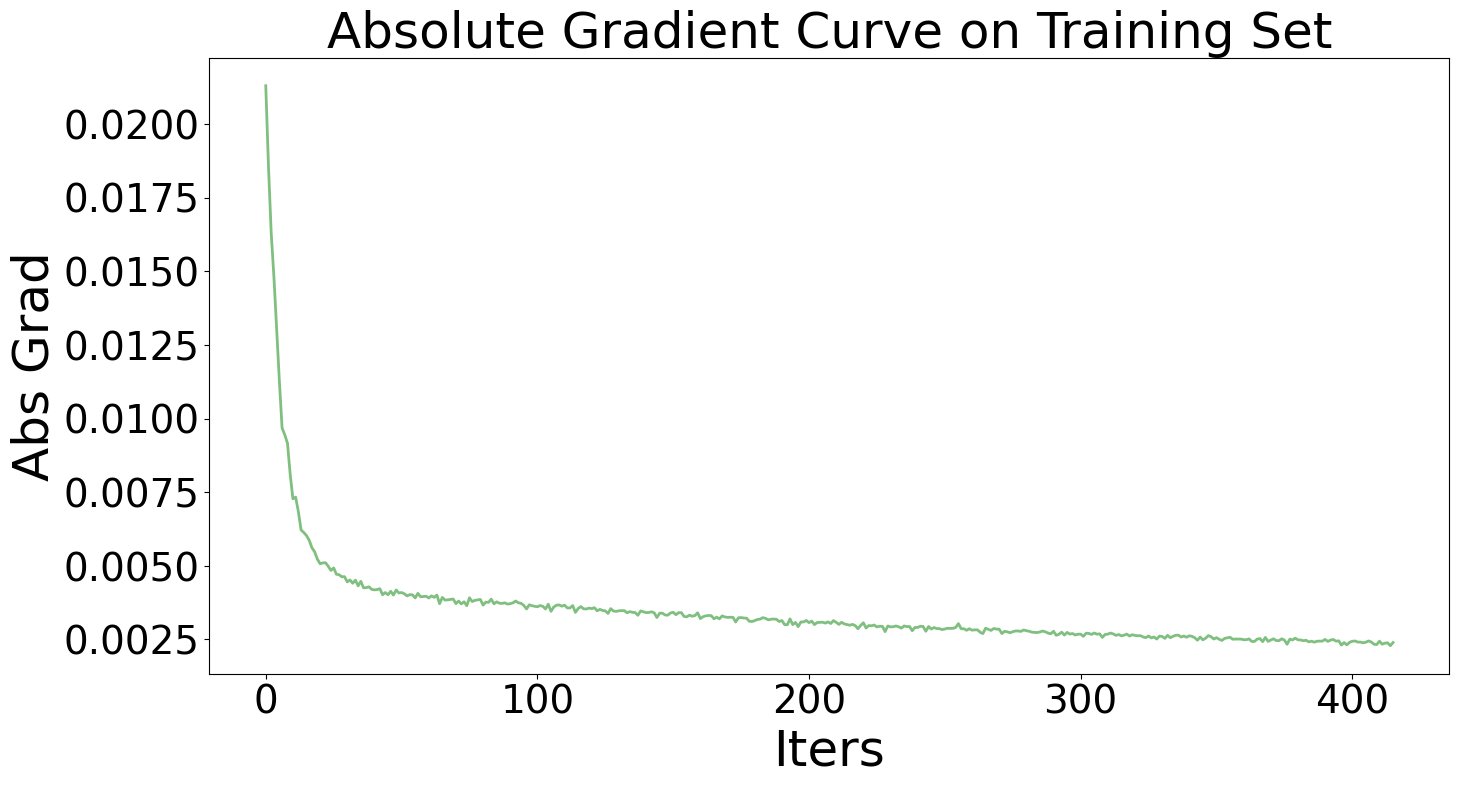

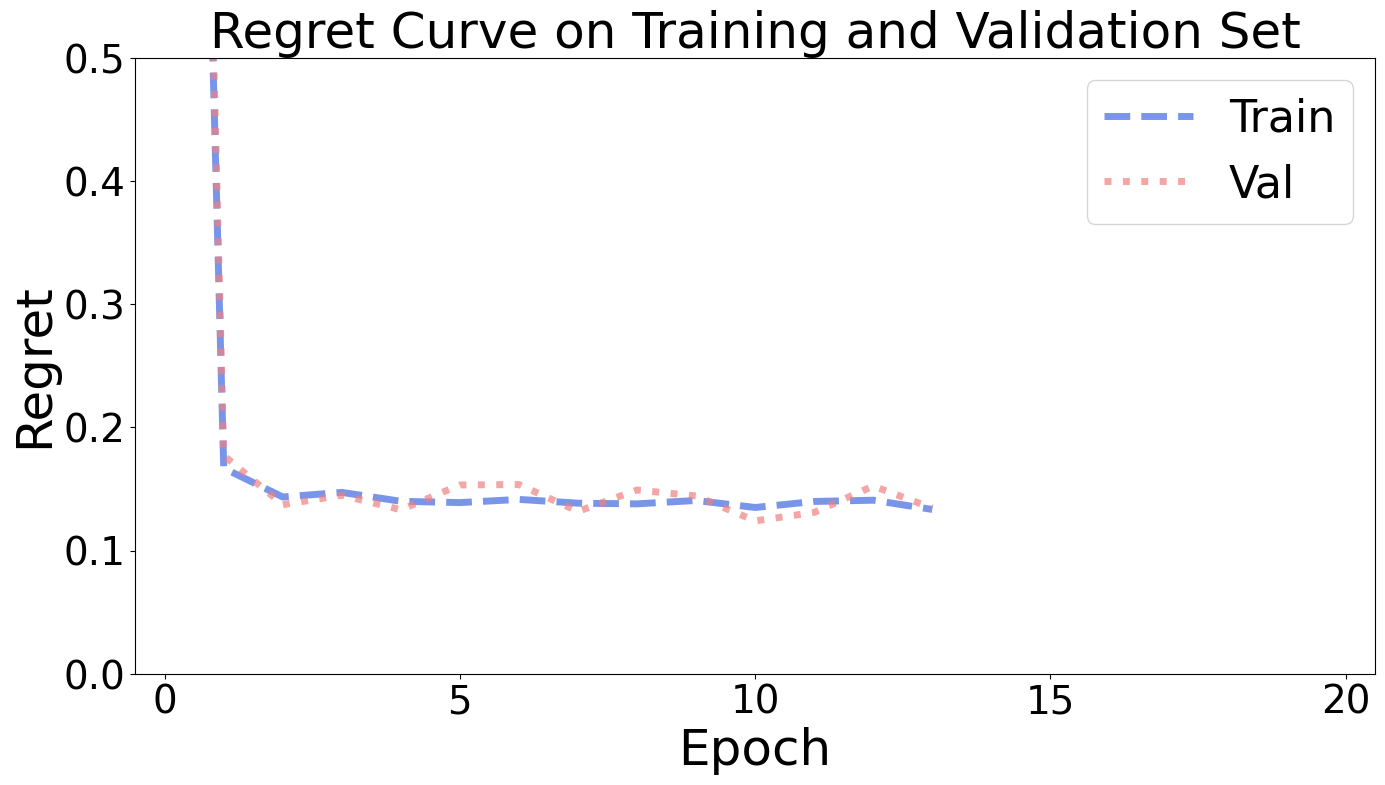

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [38]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 191.2791%, Val Regret: 188.1619%


Epoch    0, Loss:  -1.0000:   5%|██▊                                                    | 1/20 [00:19<03:17, 10.40s/it]

Epoch   1, Train Regret:  17.6349%, Val Regret:  18.5445%


Epoch    1, Loss:  -1.0000:  10%|█████▌                                                 | 2/20 [00:30<03:10, 10.59s/it]

Epoch   2, Train Regret:  14.4845%, Val Regret:  15.1415%


Epoch    2, Loss:  -1.0000:  15%|████████▎                                              | 3/20 [00:41<03:01, 10.65s/it]

Epoch   3, Train Regret:  13.3960%, Val Regret:  14.2556%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [00:52<02:51, 10.70s/it]

Epoch   4, Train Regret:  14.0140%, Val Regret:  15.0621%


Epoch    4, Loss:  -1.0000:  25%|█████████████▊                                         | 5/20 [01:04<02:43, 10.91s/it]

Epoch   5, Train Regret:  14.8095%, Val Regret:  14.6137%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [01:15<02:56, 12.59s/it]


Epoch   6, Train Regret:  13.9234%, Val Regret:  14.4394%

Early Stop!

Evaluation:
Test Regret: 14.0851%
Training Elapsed Time: 1.52 Sec


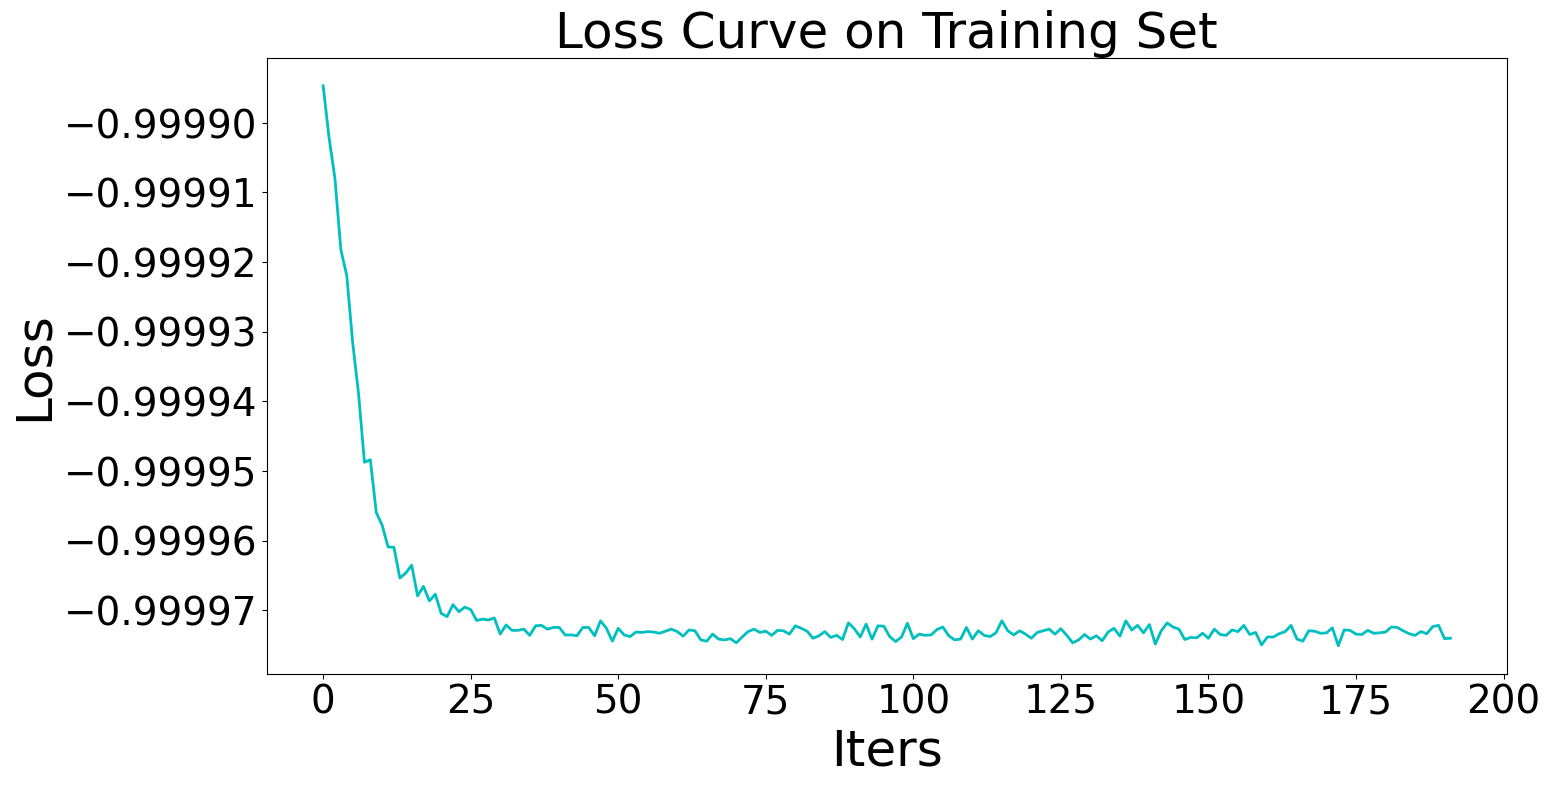

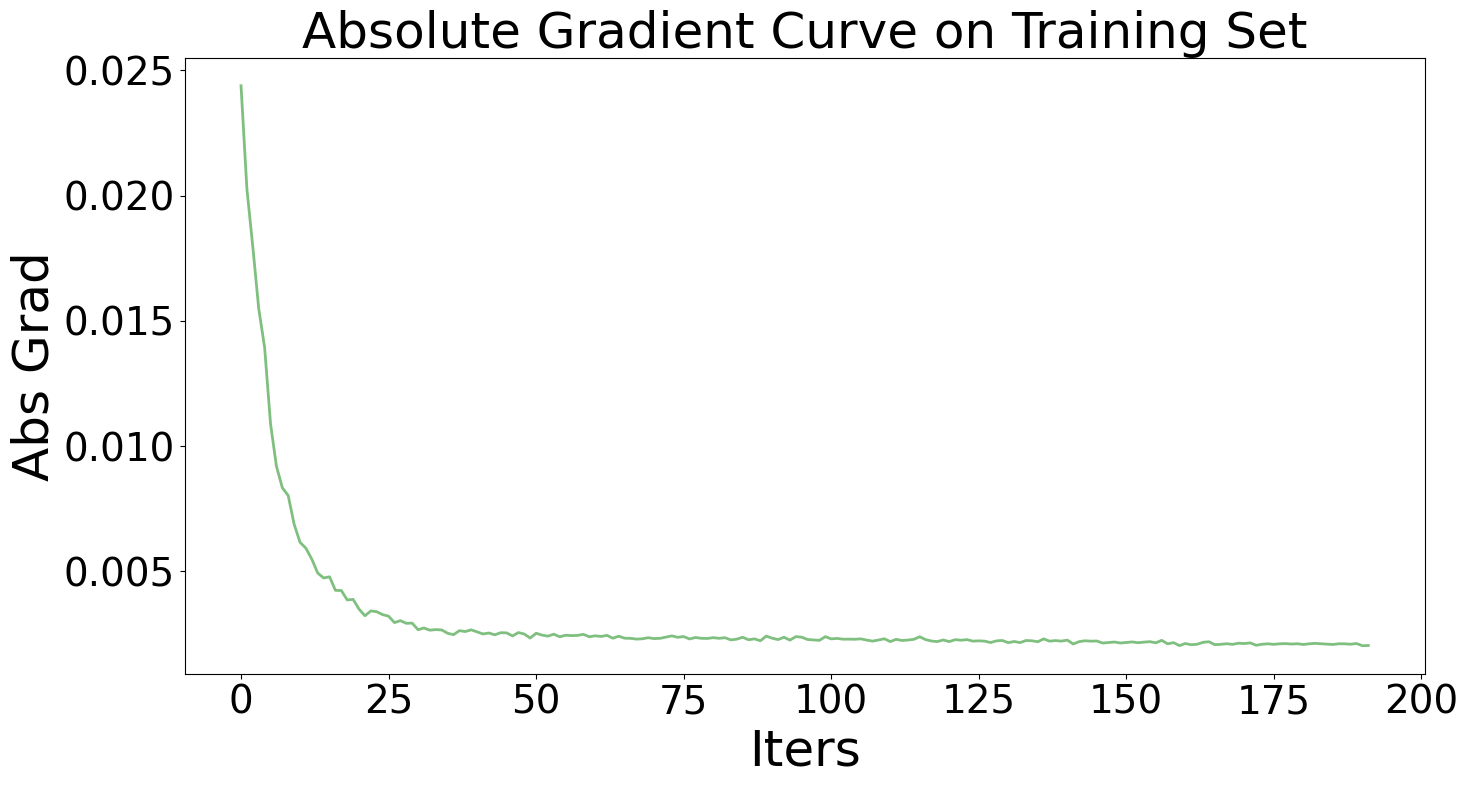

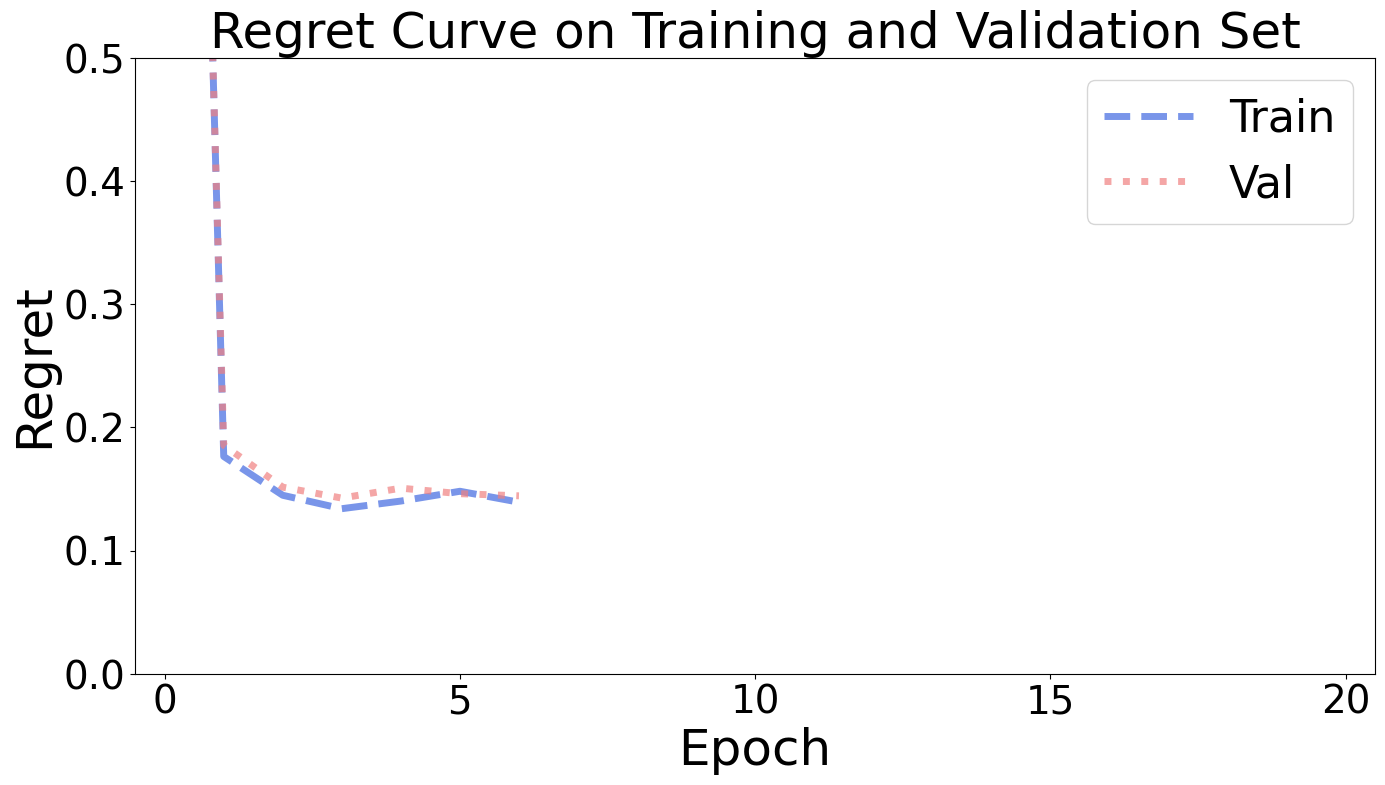

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [40]:
# init model
reg = LinearRegression()

In [41]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [42]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 204.8412%, Val Regret: 214.6115%


Epoch    0, Loss:  -1.0000:   5%|██▊                                                    | 1/20 [00:23<04:21, 13.75s/it]

Epoch   1, Train Regret:  17.3918%, Val Regret:  18.4380%


Epoch    1, Loss:  -1.0000:  10%|█████▌                                                 | 2/20 [00:37<04:12, 14.03s/it]

Epoch   2, Train Regret:  14.2201%, Val Regret:  14.1010%


Epoch    2, Loss:  -1.0000:  15%|████████▎                                              | 3/20 [00:52<04:00, 14.15s/it]

Epoch   3, Train Regret:  13.2809%, Val Regret:  14.2867%


Epoch    3, Loss:  -1.0000:  20%|███████████                                            | 4/20 [01:05<03:46, 14.17s/it]

Epoch   4, Train Regret:  13.8767%, Val Regret:  14.9608%


Epoch    4, Loss:  -1.0000:  25%|█████████████▊                                         | 5/20 [01:19<03:58, 15.88s/it]


Epoch   5, Train Regret:  15.0513%, Val Regret:  14.9822%

Early Stop!

Evaluation:
Test Regret: 14.7054%
Training Elapsed Time: 17.24 Sec


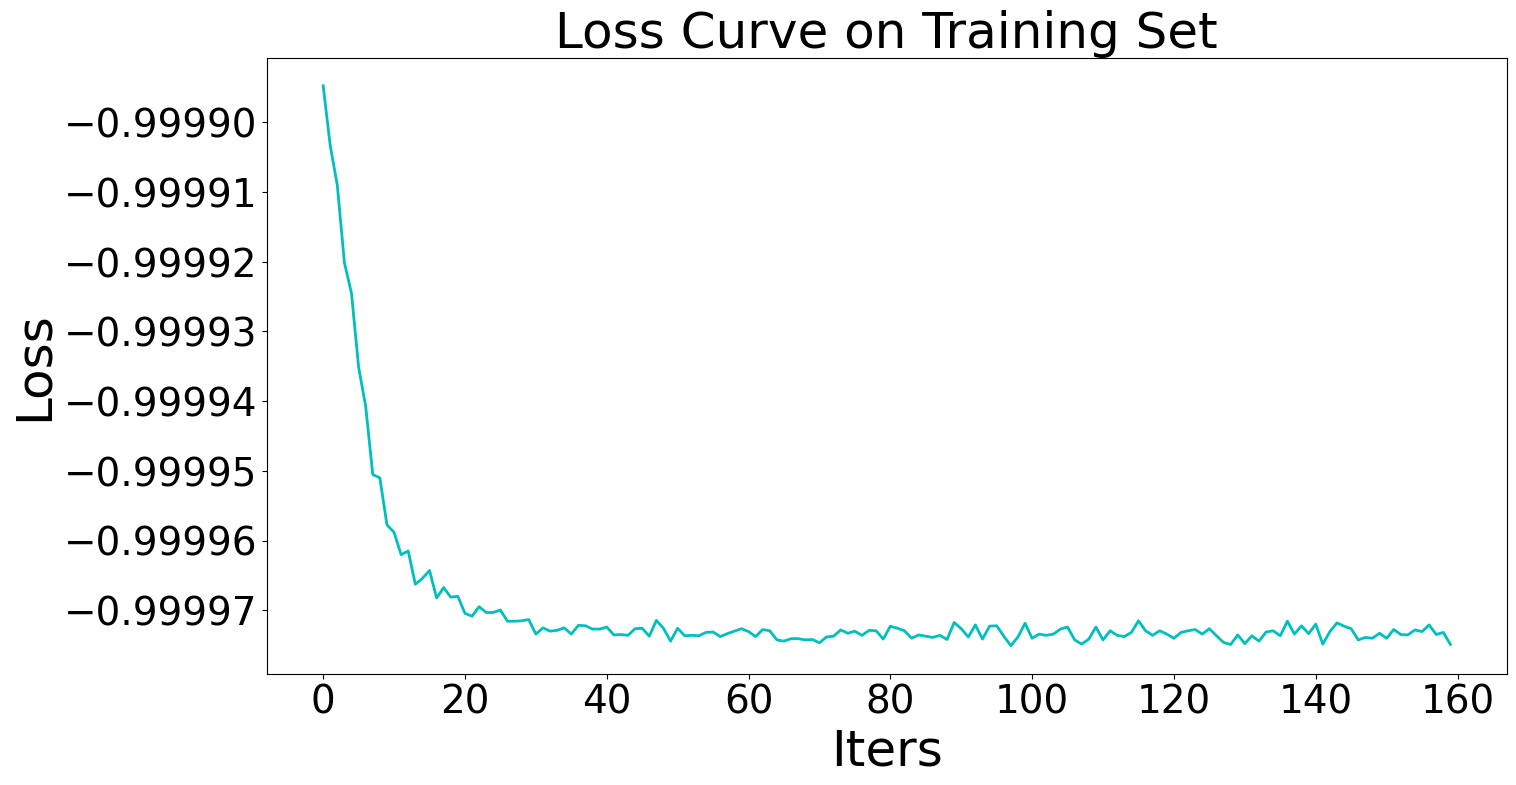

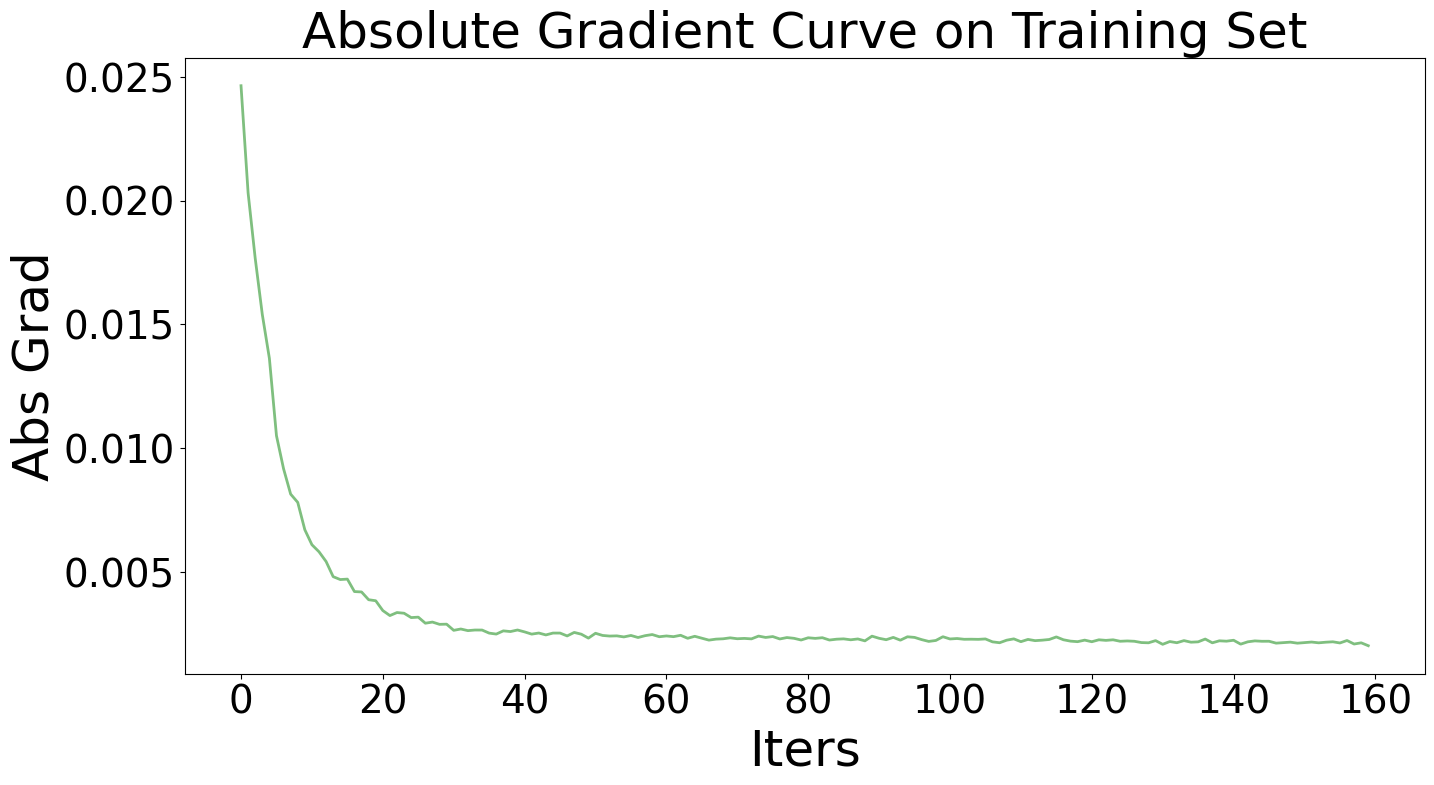

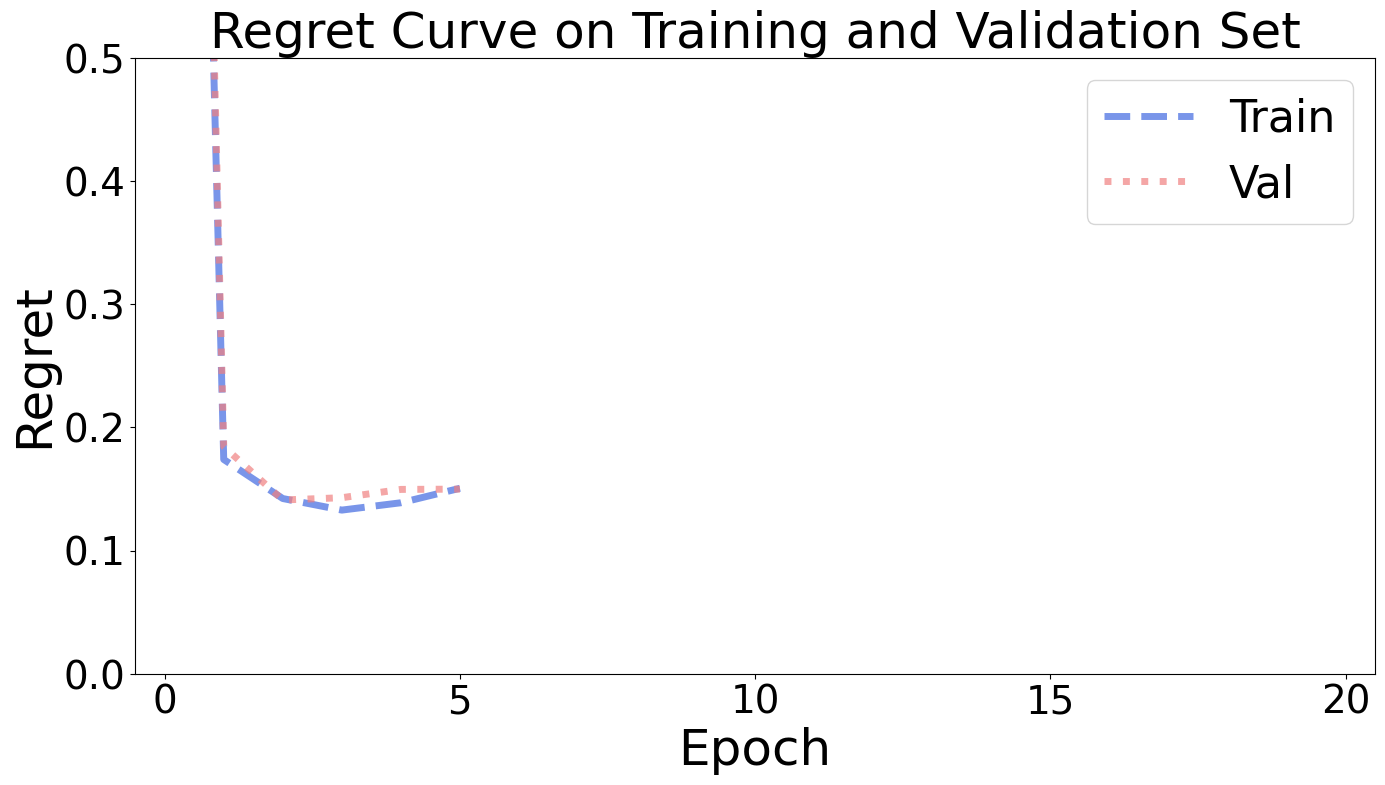

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [46]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 188.6278%, Val Regret: 199.1169%


Epoch    0, Loss:  17.7500:   5%|██▊                                                    | 1/20 [00:23<04:36, 14.53s/it]

Epoch   1, Train Regret:   8.9703%, Val Regret:   9.4095%


Epoch    1, Loss:  20.2500:  10%|█████▌                                                 | 2/20 [00:37<04:10, 13.89s/it]

Epoch   2, Train Regret:   6.9330%, Val Regret:   7.3651%


Epoch    2, Loss:  16.2500:  15%|████████▎                                              | 3/20 [00:51<03:54, 13.82s/it]

Epoch   3, Train Regret:   6.6489%, Val Regret:   7.5028%


Epoch    3, Loss:  13.0000:  20%|███████████                                            | 4/20 [01:04<03:38, 13.64s/it]

Epoch   4, Train Regret:   6.3207%, Val Regret:   7.1390%


Epoch    4, Loss:  14.2500:  25%|█████████████▊                                         | 5/20 [01:18<03:23, 13.58s/it]

Epoch   5, Train Regret:   6.1523%, Val Regret:   7.6594%


Epoch    5, Loss:  15.2500:  30%|████████████████▌                                      | 6/20 [01:31<03:10, 13.60s/it]

Epoch   6, Train Regret:   5.9718%, Val Regret:   6.7840%


Epoch    6, Loss:  17.7500:  35%|███████████████████▎                                   | 7/20 [01:45<02:56, 13.61s/it]

Epoch   7, Train Regret:   5.8757%, Val Regret:   6.3919%


Epoch    7, Loss:  16.5000:  40%|██████████████████████                                 | 8/20 [01:59<02:42, 13.58s/it]

Epoch   8, Train Regret:   5.8946%, Val Regret:   6.9686%


Epoch    8, Loss:  14.7500:  45%|████████████████████████▊                              | 9/20 [02:14<02:30, 13.72s/it]

Epoch   9, Train Regret:   5.9524%, Val Regret:   6.8366%


Epoch    9, Loss:  15.0000:  50%|███████████████████████████                           | 10/20 [02:27<02:27, 14.77s/it]


Epoch  10, Train Regret:   6.0077%, Val Regret:   7.2881%

Early Stop!

Evaluation:
Test Regret: 6.6501%
Training Elapsed Time: 30.54 Sec


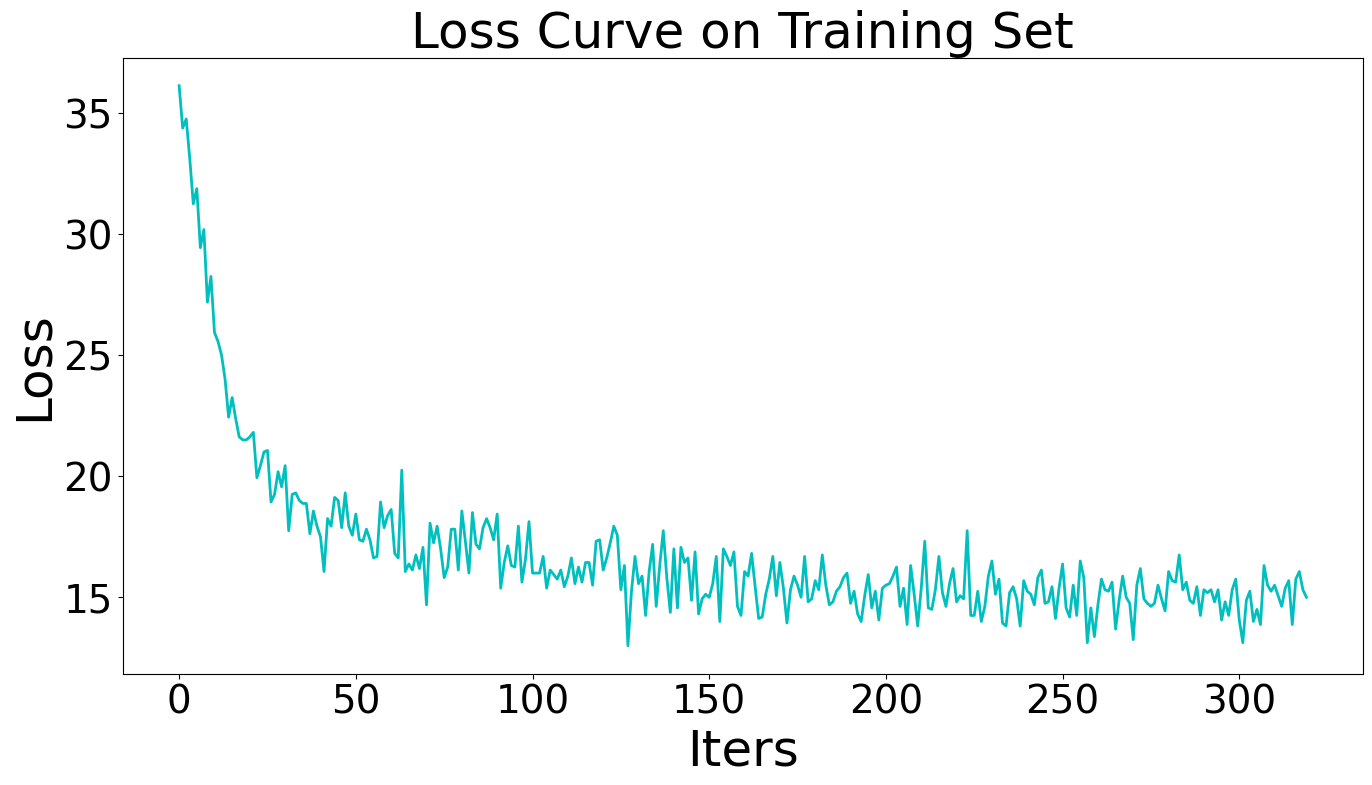

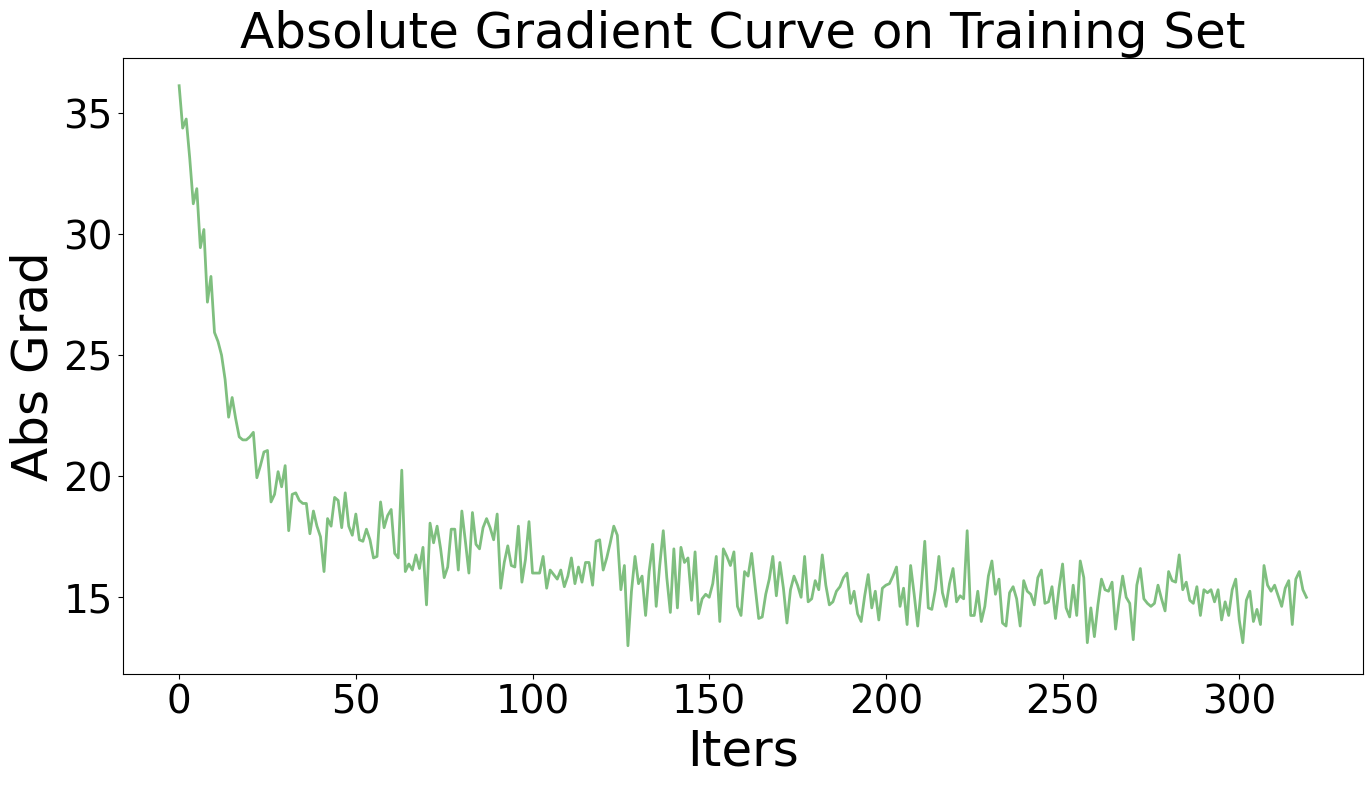

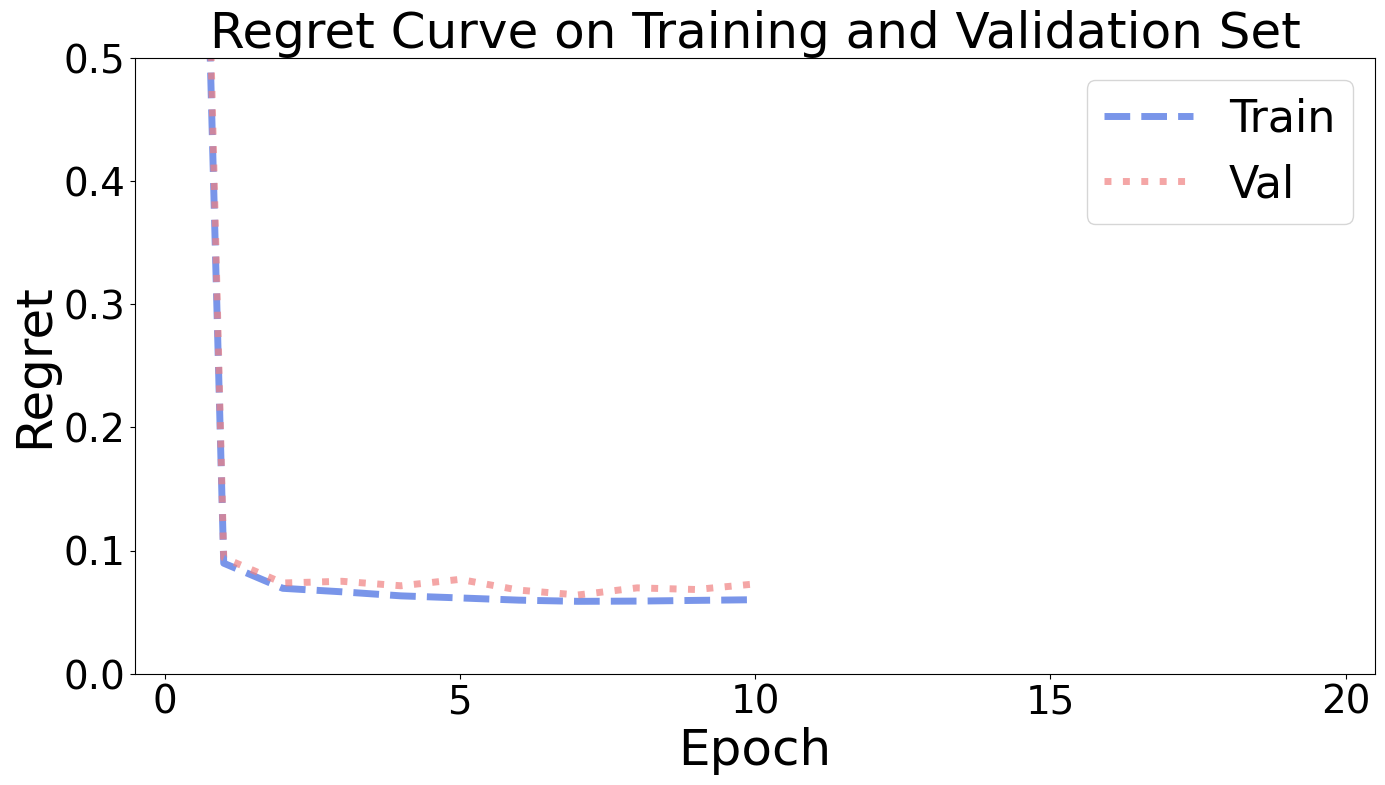

In [47]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [48]:
# init model
reg = LinearRegression()

In [49]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [50]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 206.8764%, Val Regret: 207.7709%


Epoch    0, Loss: -58.1889:   5%|██▊                                                    | 1/20 [00:20<03:25, 10.80s/it]

Epoch   1, Train Regret:  19.0112%, Val Regret:  19.1309%


Epoch    1, Loss: -123.5104:  10%|█████▍                                                | 2/20 [00:30<03:13, 10.76s/it]

Epoch   2, Train Regret:  15.2404%, Val Regret:  16.7449%


Epoch    2, Loss: -194.9332:  15%|████████                                              | 3/20 [00:41<03:02, 10.74s/it]

Epoch   3, Train Regret:  13.9691%, Val Regret:  15.8851%


Epoch    3, Loss: -298.8772:  20%|██████████▊                                           | 4/20 [00:51<02:51, 10.69s/it]

Epoch   4, Train Regret:  13.5869%, Val Regret:  15.3628%


Epoch    4, Loss: -332.7184:  25%|█████████████▌                                        | 5/20 [01:02<02:38, 10.60s/it]

Epoch   5, Train Regret:  13.1072%, Val Regret:  15.0392%


Epoch    5, Loss: -415.8187:  30%|████████████████▏                                     | 6/20 [01:12<02:27, 10.53s/it]

Epoch   6, Train Regret:  12.7586%, Val Regret:  14.3819%


Epoch    6, Loss: -428.6504:  35%|██████████████████▉                                   | 7/20 [01:24<02:17, 10.56s/it]

Epoch   7, Train Regret:  12.5156%, Val Regret:  14.5637%


Epoch    7, Loss: -434.3651:  40%|█████████████████████▌                                | 8/20 [01:36<02:11, 10.95s/it]

Epoch   8, Train Regret:  12.2817%, Val Regret:  14.6636%


Epoch    8, Loss: -612.7602:  45%|████████████████████████▎                             | 9/20 [01:46<02:10, 11.88s/it]


Epoch   9, Train Regret:  12.0932%, Val Regret:  14.5853%

Early Stop!

Evaluation:
Test Regret: 13.9432%
Training Elapsed Time: 3.57 Sec


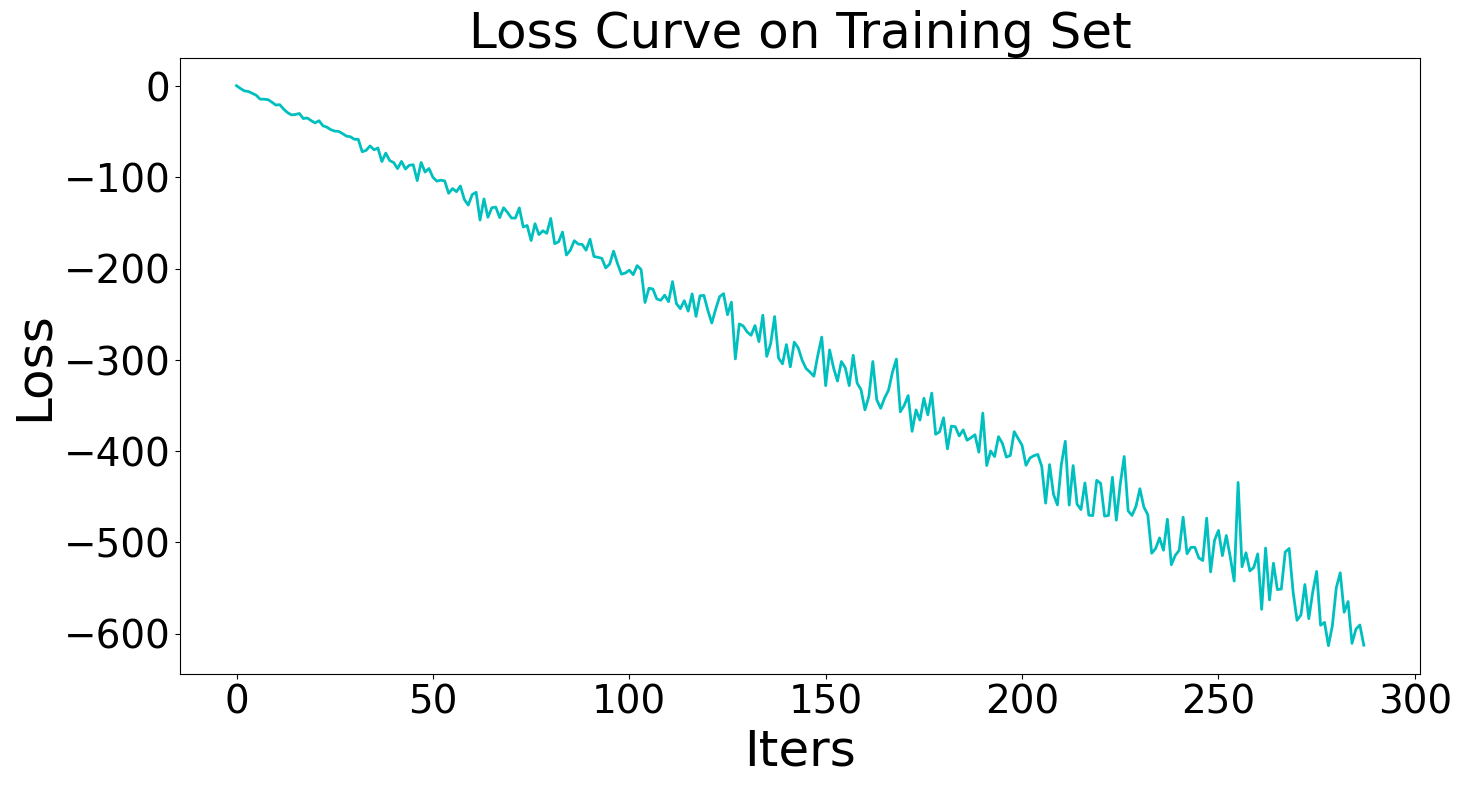

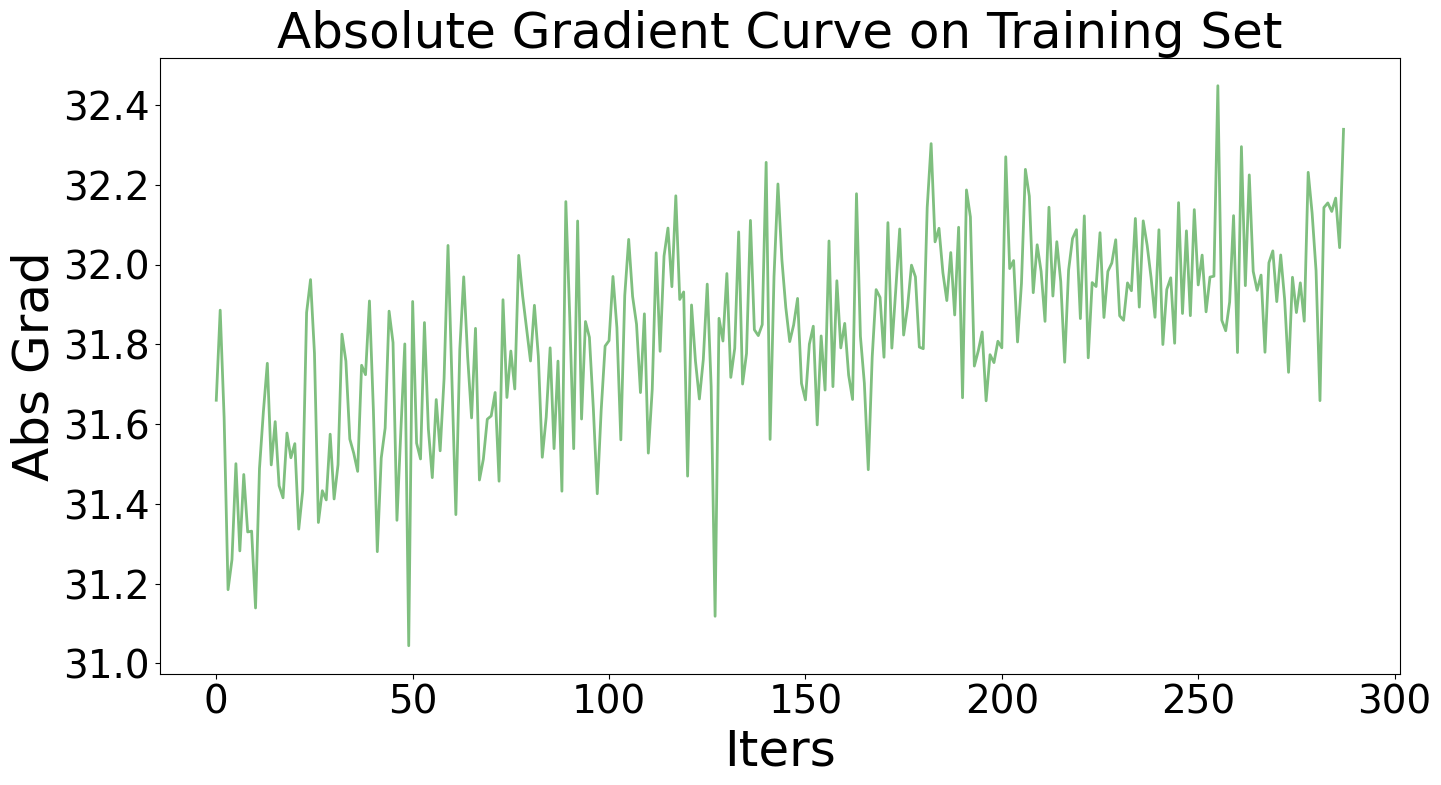

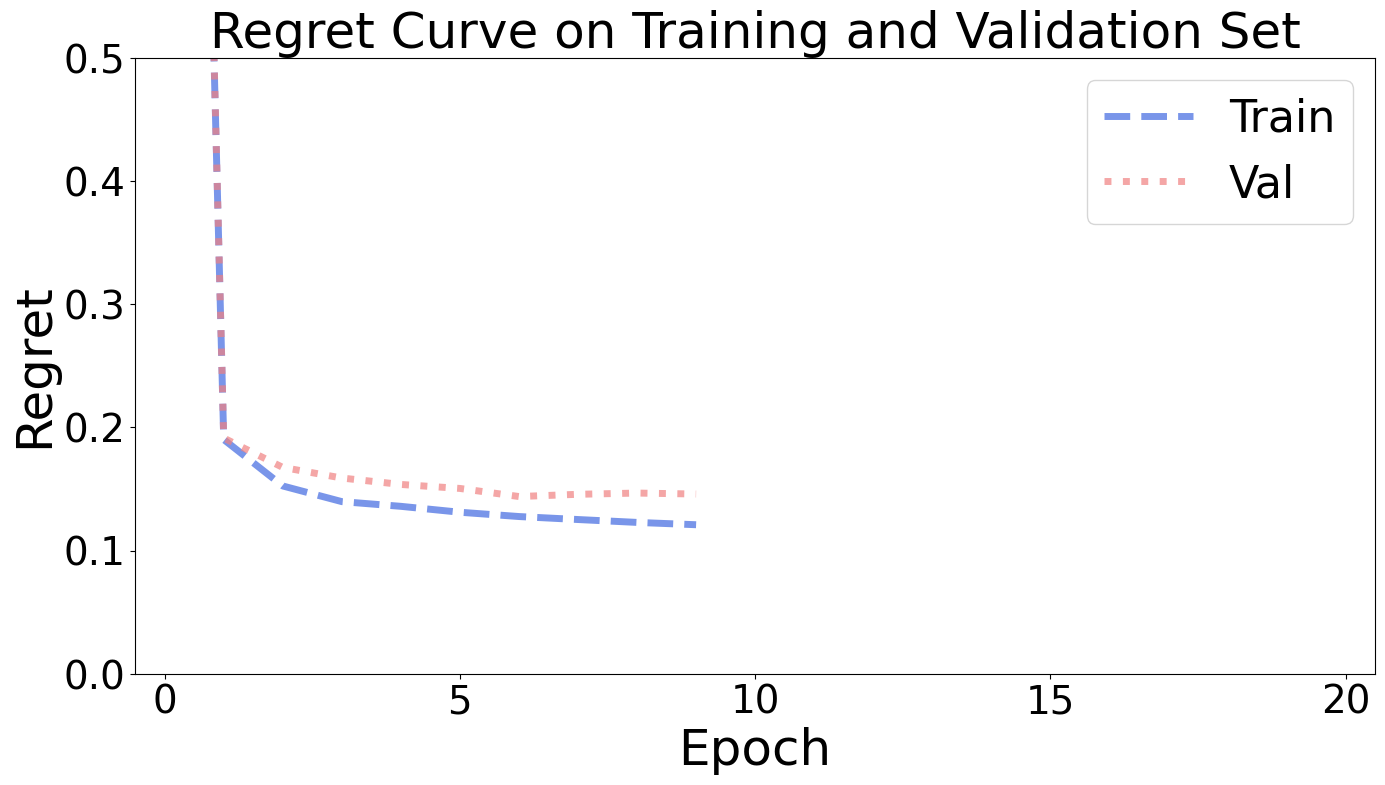

In [51]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)